# P3 Concevez une application au service de la santé publique 

L'agence <span style='color:blue'> <a href = "http://www.santepubliquefrance.fr/">"*Santé publique France*" </a></span> a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. <br>
Vous souhaitez y participer et proposer une idée d’application.

Le jeu de données <font color='orange'>Open Food Facts</font> est disponible sur le <a href = "https://world.openfoodfacts.org/">site officiel</a> (ou disponible à <a href ="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip">ce lien</a> en téléchargement).
<br>
Les variables sont définies à <a href = "https://world.openfoodfacts.org/data/data-fields.txt">cette adresse</a>

Les champs sont séparés en quatre sections :

- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.

Notre idée est de créer une application mobile nommé livebetterandlonger

Cette application permettra au utilisateur d'ameliorer leur alimentaion, en leur proposant lors de l'achat des course d'obtenir une liste de produit similaire plus sain, c'est à dire en terme possedant un meilleur nutriscore. 


Comment:
lors de la selection d'un aliment, grace à son smartphone le client scannera le code barre de l'aliment, et obtiendra une liste de produit ordonnée par qualité nutritive au moins aussi interressant que le produit scanné.

Ce notebook a pour vocation à détailler le processus de nettoyage et de traitement necessaire pour la mise en place de notre application lookalike.

Les données sont toutes issues de l'initiative Open Food Facts dans le cadre de l'appel à projets de l'Agence Santé Publique France.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import os

In [2]:
%%time
if os.path.exists("df_openfoodfacts_intermediaire.csv"):
    data_cleaned = pd.read_csv("df_openfoodfacts_intermediaire.csv",sep='\t',low_memory=False)

Wall time: 5.11 s


In [3]:
# Recuperer les colonnes à conserver
import pickle
with open('colagarder.bin','rb') as fichier:
    colgarder = pickle.load(fichier)
print(colgarder)

['code', 'product_name', 'quantity', 'categories_tags', 'serving_size', 'pnns_groups_1', 'pnns_groups_2', 'nutrition_grade_fr', 'nutrition-score-fr_100g', 'energy_100g', 'saturated-fat_100g', 'cholesterol_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'fruits-vegetables-nuts_100g', 'bocal/conserve', 'creme/sauce', 'litre', 'petit pot/yaourt', 'poids', 'unité']


In [4]:
numCol = data_cleaned[colgarder].select_dtypes(include=[np.number]).columns.tolist()

In [5]:
def compute_nb_mising_values(data):
    """
    Cree un dataframe pandas qui contient le nombre de valeurs par colonnes de l'argument data
    """
    valeurs = {}
    
    for col in data.columns:
        valeurs[col] = []
        valeurs[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        valeurs[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=valeurs, orient='index',
                                  columns = ["Taux de valeurs non nulles", "Nombre de valeurs manquantes"]
                                 ).sort_values(by="Nombre de valeurs manquantes",ascending=True)

</br>

</br>

## Imputation des valeurs manquantes

#### Le nutriscore

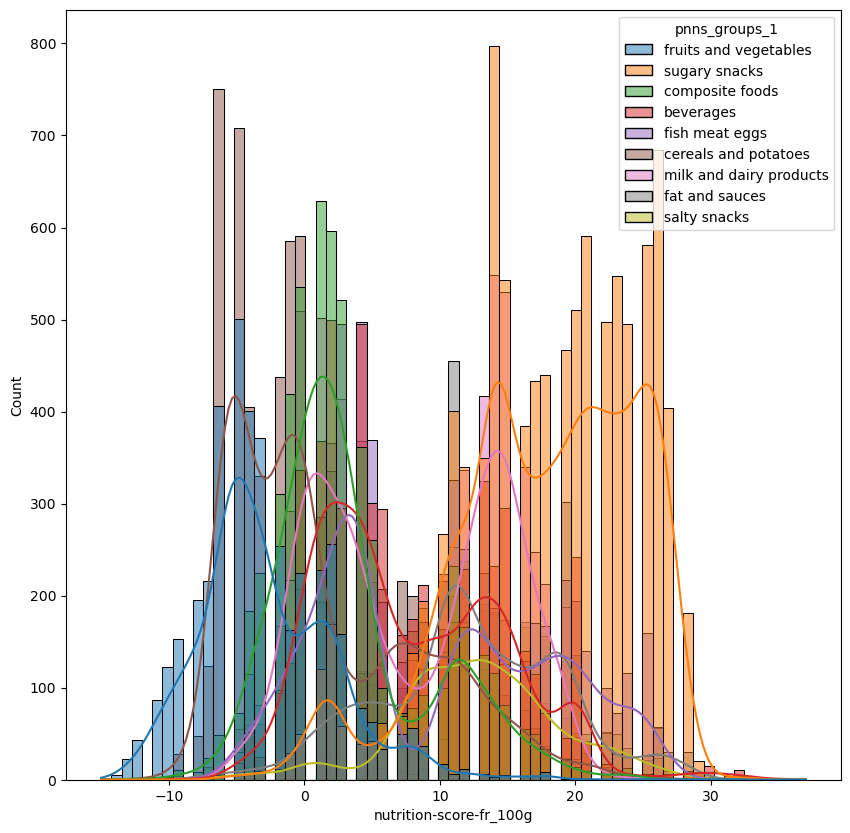

In [6]:
plt.figure(figsize=(10,10))
sns.histplot(data = data_cleaned[["nutrition-score-fr_100g","pnns_groups_1"]].dropna(), 
                 x = 'nutrition-score-fr_100g', 
                 kde = True, 
                 hue = "pnns_groups_1"
                );

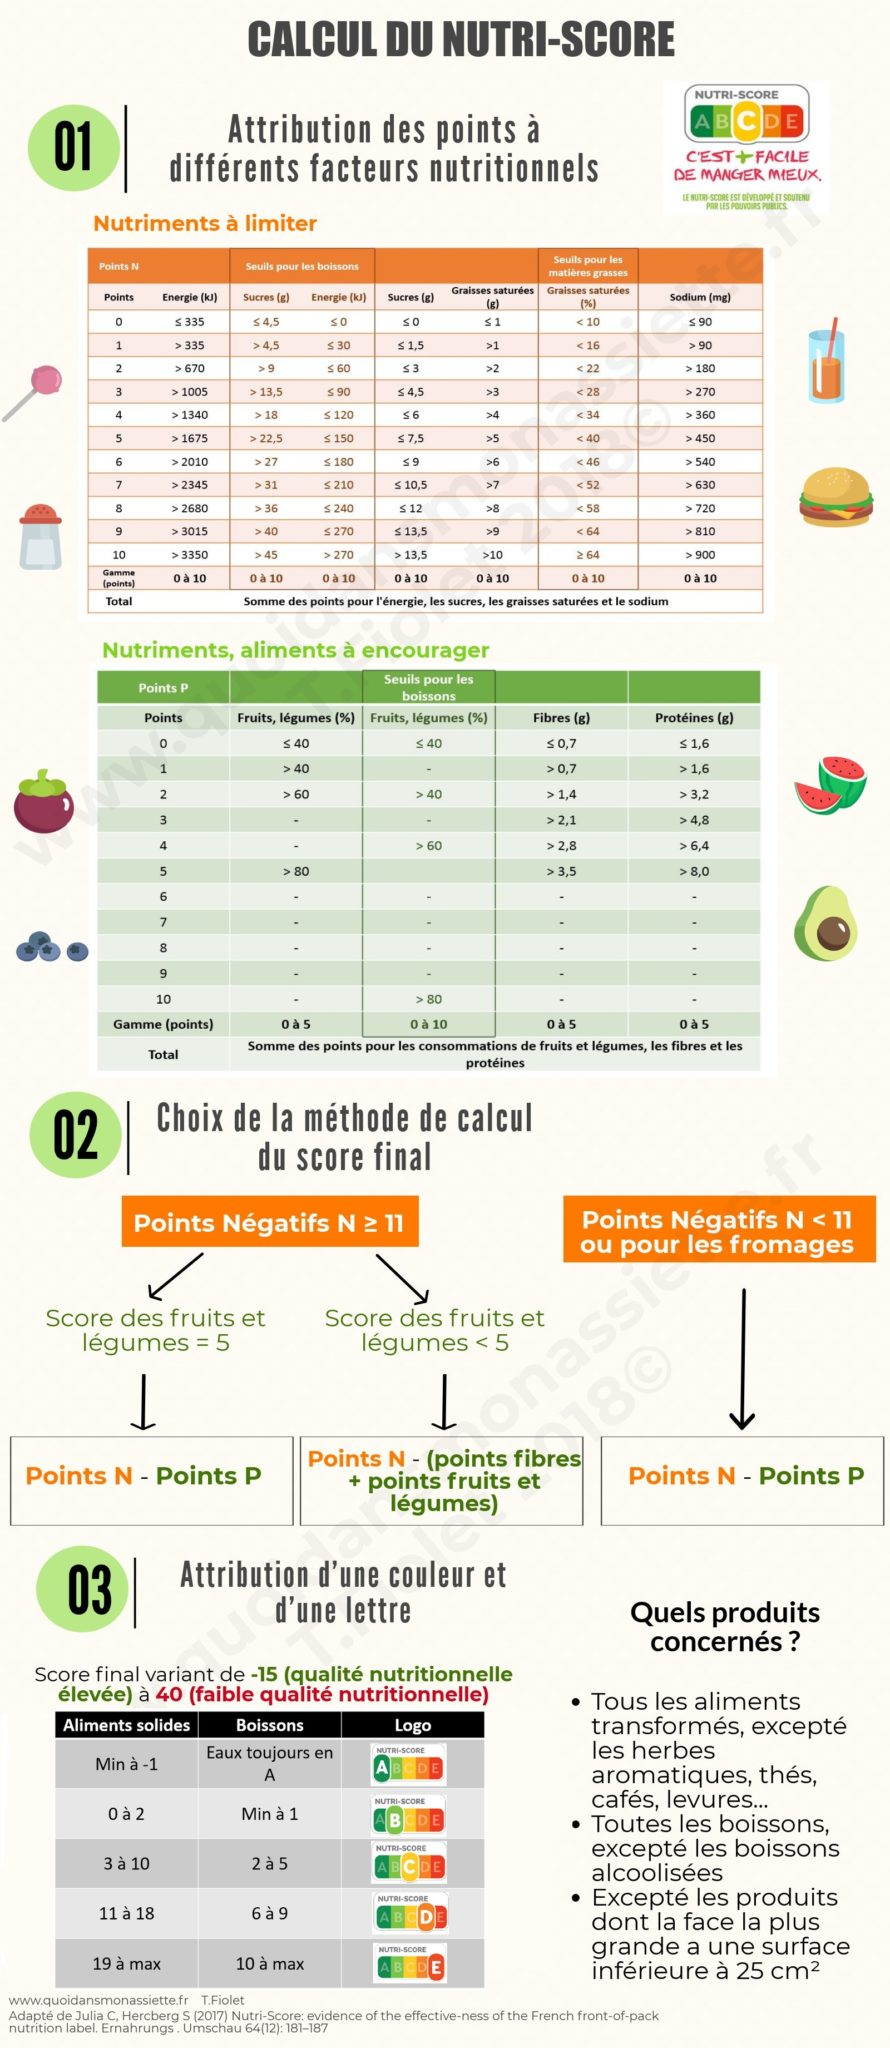

In [7]:
### Calcul du nutriscore
# cut pandas series pd.cut
# associate points with each slice

seg_NRJ = [data_cleaned.energy_100g.min()-0.001,335,670,1005,1340,1675,2010,2345,2680,3015,3350,data_cleaned.energy_100g.max()+10]
seg_NRJB = [data_cleaned.energy_100g.min()-0.001,0,30,60,90,120,150,180,210,240,270,data_cleaned.energy_100g.max()+10]

seg_sucre = [data_cleaned.sugars_100g.min()-0.001,4.5 ,9 ,13.5 ,18 ,22.5 ,27 ,31 ,36 ,40 ,45,data_cleaned.sugars_100g.max()+10]
seg_sucreB = [data_cleaned.sugars_100g.min()-0.001,0 ,1.5 ,3 ,4.5 ,6 ,7.5 ,9 ,10.5 ,12 ,13.5,data_cleaned.sugars_100g.max()+10]

seg_saturated_fat = [min(0,data_cleaned['saturated-fat_100g'].min())-0.001, 1,2,3,4,5,6,7,8,9,10,data_cleaned['saturated-fat_100g'].max()+10]
seg_saturated_fatSFat = [min(0,data_cleaned['saturated-fat_100g'].min())-0.001, 10,16,22,28,34,40,46,52,58,64,max(100,data_cleaned['saturated-fat_100g'].max()+10)]

seg_sodium = [data_cleaned.sodium_100g.min()-0.001,90,180,270,360,450,540,630,720,810,900,max(1000,data_cleaned.sodium_100g.max()+10)]

seg_fiber = [data_cleaned.fiber_100g.min()-0.001,0.7,1.4,2.1,2.8,3.5,data_cleaned.fiber_100g.max()+10]
seg_fruit_nuts = [data_cleaned['fruits-vegetables-nuts_100g'].min()-0.001,40,60,80,data_cleaned['fruits-vegetables-nuts_100g'].max()+10]
seg_fruit_nutsB = [data_cleaned['fruits-vegetables-nuts_100g'].min()-0.001,40,60,80,data_cleaned['fruits-vegetables-nuts_100g'].max()+10]

seg_proteins = [data_cleaned.proteins_100g.min(),1.6,3.2,4.8,6.4,8,data_cleaned.proteins_100g.max()+10]


In [8]:
##### les éléments négatifs
data_cleaned["ptsAa"] = 0
data_cleaned["ptsAb"] = 0
data_cleaned["ptsAc"] = 0
data_cleaned["ptsAd"] = 0


data_cleaned["pnns_groups_1"].fillna('unknown',inplace=True)
data_cleaned["pnns_groups_2"].fillna('unknown',inplace=True)


# Energy boissons
data_cleaned.loc[data_cleaned.pnns_groups_1 == 'beverages',["ptsAa"]] = pd.cut(data_cleaned.energy_100g[data_cleaned.pnns_groups_1 == 'beverages'],
                                                                          bins=seg_NRJB,labels=range(11), right=True).astype(np.float64)

# Energy autres que boissons
data_cleaned.loc[data_cleaned.pnns_groups_1 != 'beverages',["ptsAa"]] = pd.cut(data_cleaned.energy_100g[data_cleaned.pnns_groups_1 != 'beverages'],
       bins=seg_NRJ,labels=range(11), right=False).astype(np.float64)

# Sugar Boissons
data_cleaned.loc[data_cleaned.pnns_groups_1 == 'beverages',["ptsAb"]] = pd.cut(data_cleaned[data_cleaned.pnns_groups_1 == 'beverages'].sugars_100g,
bins=seg_sucreB,labels=range(11), right=True).astype(np.float64)

# Sugar autres aliments
data_cleaned.loc[data_cleaned.pnns_groups_1 != 'beverages',["ptsAb"]] = pd.cut(data_cleaned[data_cleaned.pnns_groups_1 != 'beverages'].sugars_100g,
                                                                          bins=seg_sucre,labels=range(11), right=False).astype(np.float64)

#Saturated fat Mat Grasses
data_cleaned.loc[data_cleaned.pnns_groups_2 == 'fats',["ptsAc"]] = pd.cut(data_cleaned[data_cleaned.pnns_groups_2 == 'fats']['saturated-fat_100g'],
                                                                     bins=seg_saturated_fatSFat,labels=range(11), right=False).astype(np.float64)

#Saturated fat autres aliments
data_cleaned.loc[data_cleaned.pnns_groups_2 != 'fats',["ptsAc"]] = pd.cut(data_cleaned[data_cleaned.pnns_groups_2 != 'fats']['saturated-fat_100g'],
                                                                     bins=seg_saturated_fat,labels=range(11)).astype(np.float64)

#Sodium
data_cleaned["ptsAd"] = pd.cut(data_cleaned.sodium_100g*1000,bins=seg_sodium,labels=range(11)).astype(np.float64)



##### les éléments positifs
data_cleaned["ptsCa"] = 0
data_cleaned["ptsCb"] = 0
data_cleaned["ptsCc"] = 0


#Fibre
data_cleaned["ptsCb"] = pd.cut(data_cleaned.fiber_100g,bins=seg_fiber,labels=[0,1,2,3,4,5]).astype(np.float64)

#Fruits et noix
data_cleaned.loc[data_cleaned.pnns_groups_1 != 'beverages',["ptsCa"]] = pd.cut(data_cleaned.loc[data_cleaned.pnns_groups_1 != 'beverages']['fruits-vegetables-nuts_100g'],
       bins=seg_fruit_nuts,labels=[0,1,2,5]).astype(np.float64)

#Fruits et noix Boissons
data_cleaned.loc[data_cleaned.pnns_groups_1 == 'beverages',["ptsCa"]] = pd.cut(data_cleaned.loc[data_cleaned.pnns_groups_1 == 'beverages']['fruits-vegetables-nuts_100g'],
                                                                              bins=seg_fruit_nutsB,labels=[0,2,4,10]).astype(np.float64)

#Proteins
data_cleaned["ptsCc"] = pd.cut(data_cleaned.proteins_100g,bins=seg_proteins, labels = [0,1,2,3,4,5]).astype(np.float64)


# estimation nutriscore
data_cleaned[['ptsAa','ptsAb','ptsAc','ptsAd','ptsCa','ptsCb','ptsCc']] = data_cleaned[['ptsAa','ptsAb','ptsAc','ptsAd','ptsCa','ptsCb','ptsCc']].fillna(0)
data_cleaned['estimatedNS'] = data_cleaned['ptsAa'] + data_cleaned['ptsAb'] + data_cleaned['ptsAc'] + data_cleaned['ptsAd'] - data_cleaned['ptsCa'] - data_cleaned['ptsCb'] - data_cleaned['ptsCc']


#for k in range(data_cleaned.shape[0]):
#    if (data_cleaned.ptsAa.values[k] + data_cleaned.ptsAb.values[k] + data_cleaned.ptsAc.values[k]+ data_cleaned.ptsAd.values[k] >=11) & (data_cleaned.ptsCa.values[k] < 5) :
#        data_cleaned.loc[k,['estimatedNS']] = data_cleaned.ptsAa.values[k] + data_cleaned.ptsAb.values[k] + data_cleaned.ptsAc.values[k]+ data_cleaned.ptsAd.values[k] - data_cleaned.ptsCa.values[k] - data_cleaned.ptsCb.values[k]

In [9]:
pd.set_option('max_colwidth', None)
pd.set_option("display.max_rows", 200) #parametre le nombre de ligne affichable dans dataframe pandas
pd.set_option("expand_frame_repr", True) #permet de deplier les colonnes cachées
pd.set_option("display.max_columns",200 ) #permet d'afficher jusqu'à 200 colonnes dans une cellule

In [10]:
compute_nb_mising_values(data_cleaned)

Taux de valeurs non nulles  \
code                                                         100.00   
ptsCb                                                        100.00   
ptsCa                                                        100.00   
ptsAd                                                        100.00   
ptsAc                                                        100.00   
ptsAb                                                        100.00   
ptsAa                                                        100.00   
unité                                                        100.00   
poids                                                        100.00   
petit pot/yaourt                                             100.00   
litre                                                        100.00   
creme/sauce                                                  100.00   
bocal/conserve                                               100.00   
ptsCc                                                        100.00   
pnns_groups_2                                                100.00   
pnns_groups_1                                                100.00   
estimatedNS                                                  100.00   
last_modified_t                                              100.00   
url                                                          100.00   
created_t                                                    100.00   
creator                                                      100.00   
states_tags                                                   99.99   
countries_fr                                                  99.92   
product_name                                                  94.43   
brands_tags                                                   91.14   
unites                                                        84.79   
unites_abb                                                    84.79   
energy_100g                                                   81.01   
salt_100g                                                     79.55   
ingredients_that_may_be_from_palm_oil_n                       77.45   
additives_n                                                   77.45   
ingredients_text                                              77.45   
ingredients_from_palm_oil_n                                   77.45   
proteins_100g                                                 77.05   
fat_100g                                                      75.87   
carbohydrates_100g                                            75.78   
sodium_100g                                                   74.42   
sugars_100g                                                   71.54   
nutrition_grade_fr                                            68.96   
nutrition-score-uk_100g                                       68.96   
nutrition-score-fr_100g                                       68.96   
saturated-fat_100g                                            66.15   
serving_size                                                  65.61   
fiber_100g                                                    58.13   
additives_tags                                                48.11   
trans-fat_100g                                                44.41   
iron_100g                                                     41.47   
calcium_100g                                                  39.94   
cholesterol_100g                                              38.15   
vitamin-a_100g                                                37.34   
vitamin-c_100g                                                36.65   
quantity                                                      32.96   
categories_tags                                               26.55   
main_category_fr                                              26.54   
packaging_tags                                                24.83   
image_small_url                                               23.

In [11]:
data_cleaned.drop(columns=['ptsAa','ptsAb','ptsAc','ptsAd','ptsCa','ptsCb','ptsCc'],inplace=True)

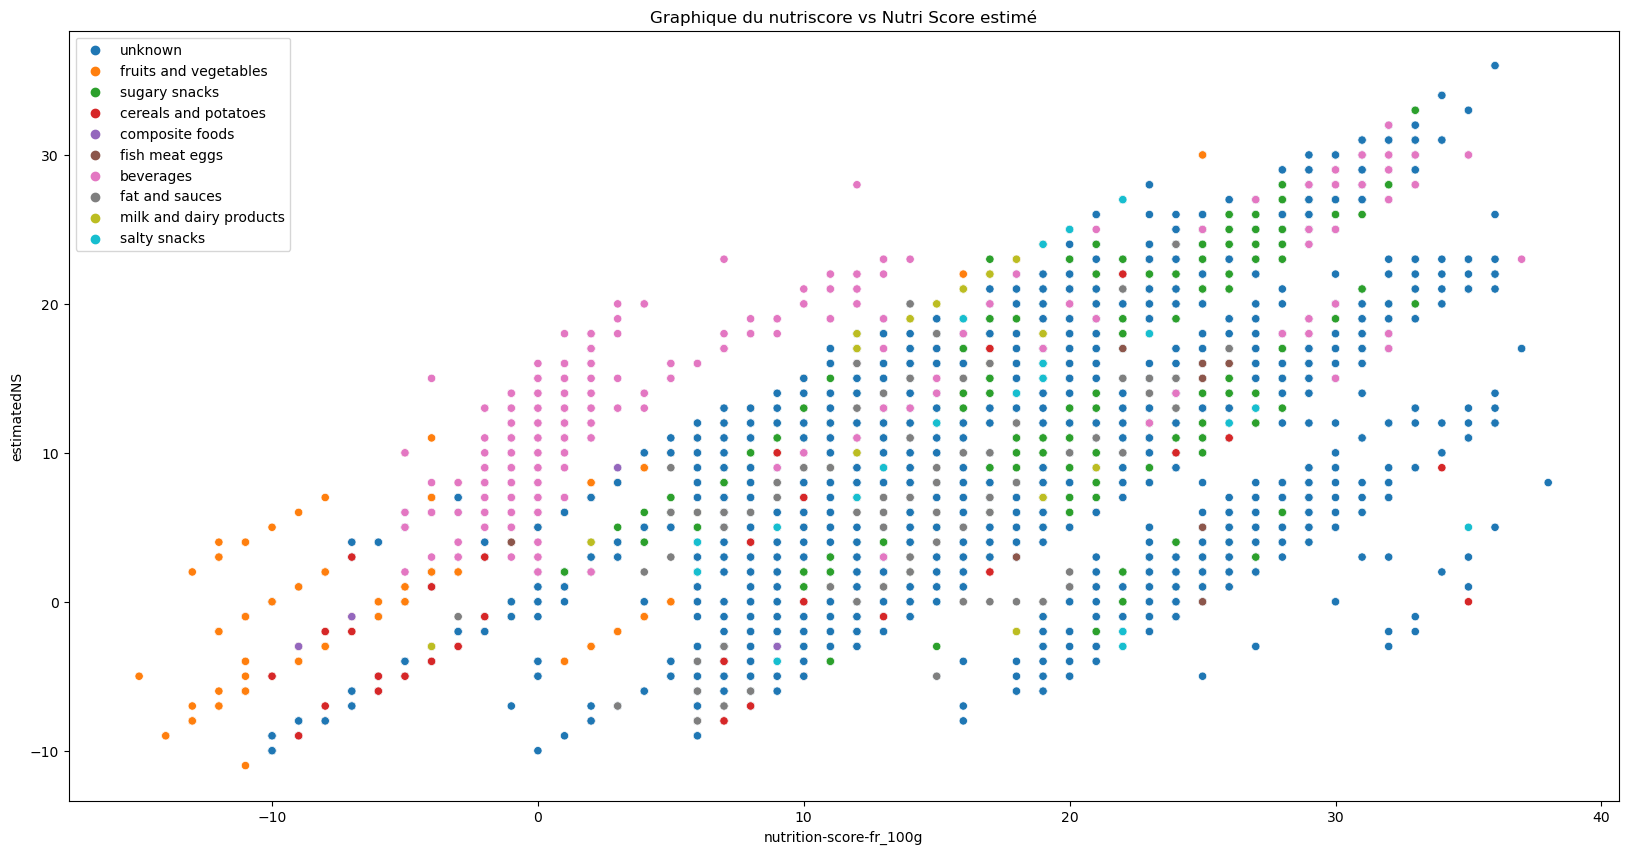

In [12]:
plt.figure(figsize = (20,10))
sns.scatterplot(y = 'estimatedNS',x = data_cleaned.loc[data_cleaned.code.notna(),'nutrition-score-fr_100g'] , data=data_cleaned,hue='pnns_groups_1')
plt.legend(loc='upper left')
plt.title('Graphique du nutriscore vs Nutri Score estimé');

Notre estimation est mauvaise

In [13]:
data_cleaned.loc[data_cleaned.pnns_groups_1=='unknown',["pnns_groups_1"]] = np.nan
data_cleaned.loc[data_cleaned.pnns_groups_2=='unknown',["pnns_groups_2"]] = np.nan

In [14]:
data_cleaned[data_cleaned['nutrition-score-fr_100g'].notna()].estimatedNS.values-data_cleaned[data_cleaned['nutrition-score-fr_100g'].notna()]['nutrition-score-fr_100g'].values

array([-12.,   0.,  -5., ...,   5.,   0.,   0.])

In [15]:
print("L'érreur quadratique moyenne est de {}".format( np.sum((data_cleaned[data_cleaned['nutrition-score-fr_100g'].notna()].estimatedNS.values-data_cleaned[data_cleaned['nutrition-score-fr_100g'].notna()]['nutrition-score-fr_100g'].values)**2/data_cleaned.shape[0] ) ) )

L'érreur quadratique moyenne est de 25.783361107954903


<AxesSubplot:xlabel='nutrition-score-fr_100g', ylabel='Density'>

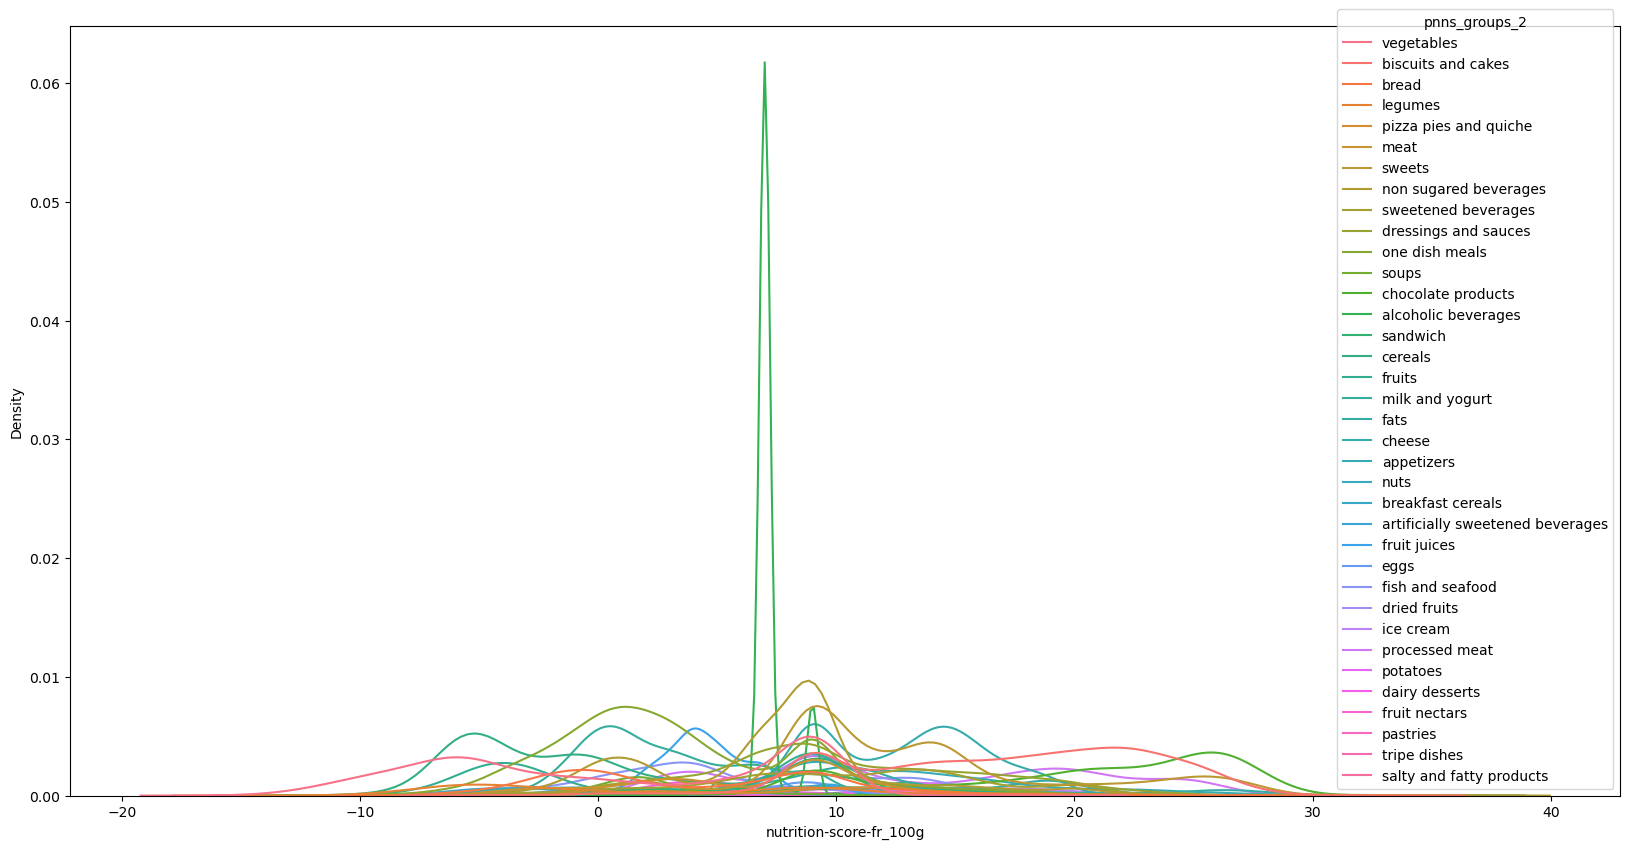

In [113]:
plt.figure(figsize=(20,10))
sns.kdeplot(data=data_cleaned, x='nutrition-score-fr_100g',hue = 'pnns_groups_2')

</br>

### Données numeriques conservées

Deux imputer fourni par sklearn seront testés.</br>
Un jeu d'entrainement A qui représente 20% sera tiré de façon aléatoire¨à partir de notre dataset.
Des valeurs manquantes seront générées aléatoirement dans A.
La metrique de comparaison des imputer sera le RMSE et le MAE.

##### train test na data

Certaines colonnes ne seront pas inclus dans le test car elle contiennent trop de valeurs manquantes.

In [16]:
na_df = data_cleaned[['nutrition-score-fr_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 #'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'sodium_100g',
 #'vitamin-a_100g',
 #'vitamin-c_100g',
 'calcium_100g',
 'iron_100g',
 #'fruits-vegetables-nuts_100g',
 'bocal/conserve',
 'creme/sauce',
 'litre',
 'petit pot/yaourt',
 'poids',
 'unité']].dropna().copy().values

idNan = np.random.choice(np.arange(na_df.ravel().size), size=round((na_df.shape[0] * na_df.shape[1])*0.5), replace=False)
Xna = na_df.ravel()

XnaDF = pd.DataFrame({'Xna':Xna})
XnaDF.iloc[idNan] = np.nan
Xna = XnaDF.Xna.values

del XnaDF

In [17]:
len(idNan)

802827

<div class="alert alert-block alert-info">Score a battre</div>

In [18]:
print("L'érreur quadratique d'une imputation par la moyenne est de ", np.sum((np.mean(na_df.ravel()) - na_df.ravel())**2/len(na_df.ravel()) ) )
print("L'érreur median absolu d'une imputation par la moyenne est de ", np.sum(abs(na_df.ravel() - na_df.ravel())/len(na_df.ravel()) ) ,"!!! C'est normal")

L'érreur quadratique d'une imputation par la moyenne est de  85696.44846539001
L'érreur median absolu d'une imputation par la moyenne est de  0.0 !!! C'est normal


##### KNN Imputer

##### expérimental Imputer

In [19]:
%%time
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(Xna.reshape(-1, 1))
IterativeImputer(random_state=0)
# the model learns that the second feature is double the first
XimputeExperi = np.round(imp.transform(Xna.reshape(-1, 1)),2)

Wall time: 556 ms


In [20]:
print("L'érreur quadratique moyenne est de ", np.sum((XimputeExperi.ravel() - na_df.ravel())**2/len(na_df.ravel()) ) )
print("L'érreur median Absolue est de ", np.sum(abs(XimputeExperi.ravel() - na_df.ravel())/len(na_df.ravel()) ) )

L'érreur quadratique moyenne est de  42605.53034980459
L'érreur median Absolue est de  54.39227854145505


<div class="alert alert-block alert-info">
    L'imputer knn est le moins efficace avec des temps d'execution beaucoup plus long
</div>

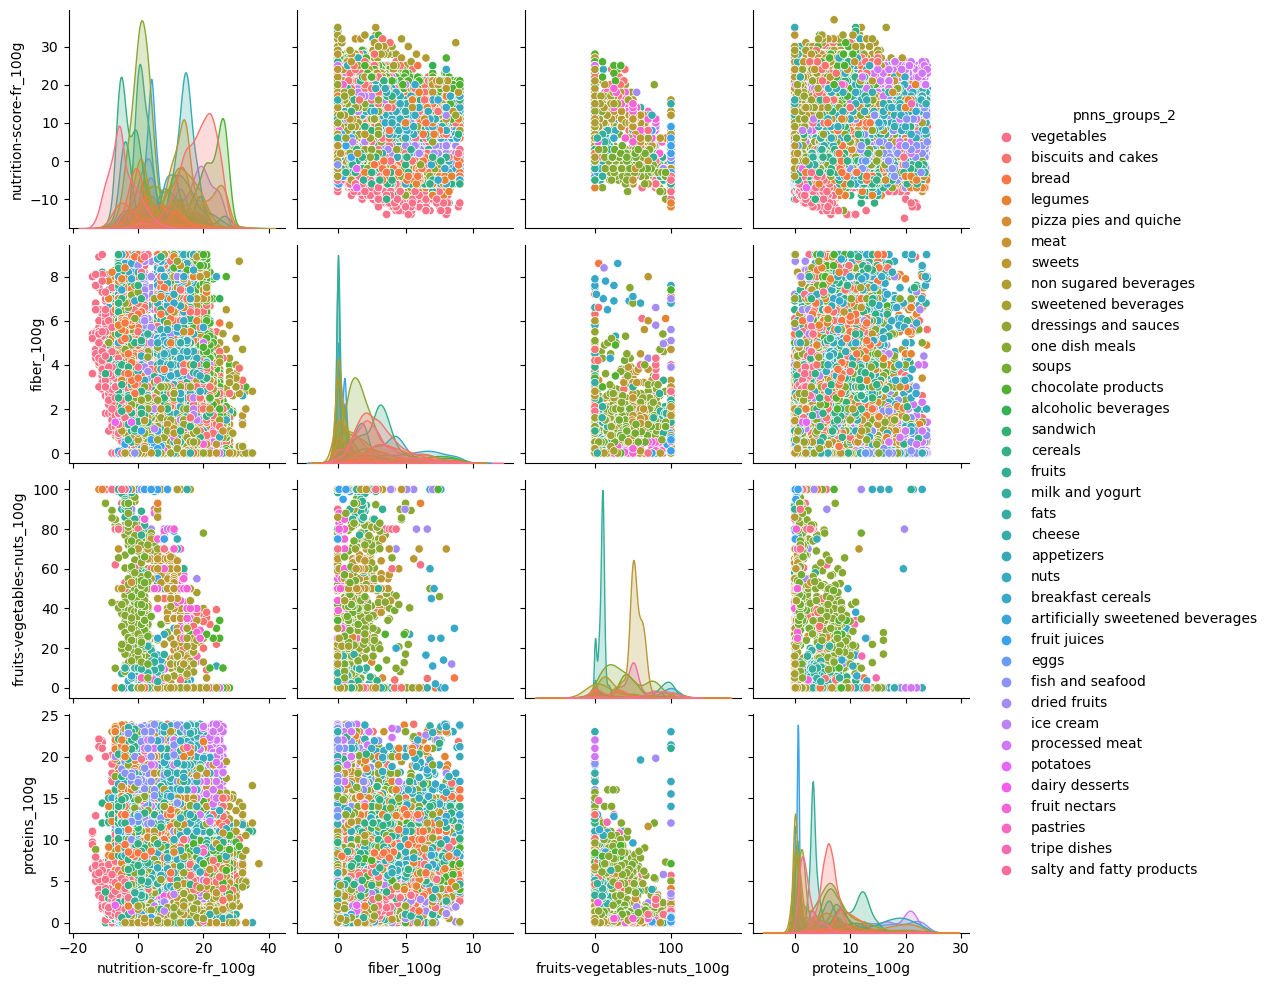

In [21]:
sns.pairplot(data=data_cleaned[['nutrition-score-fr_100g', 'fiber_100g', 'fruits-vegetables-nuts_100g',
                                'proteins_100g', 'pnns_groups_2']],hue='pnns_groups_2')

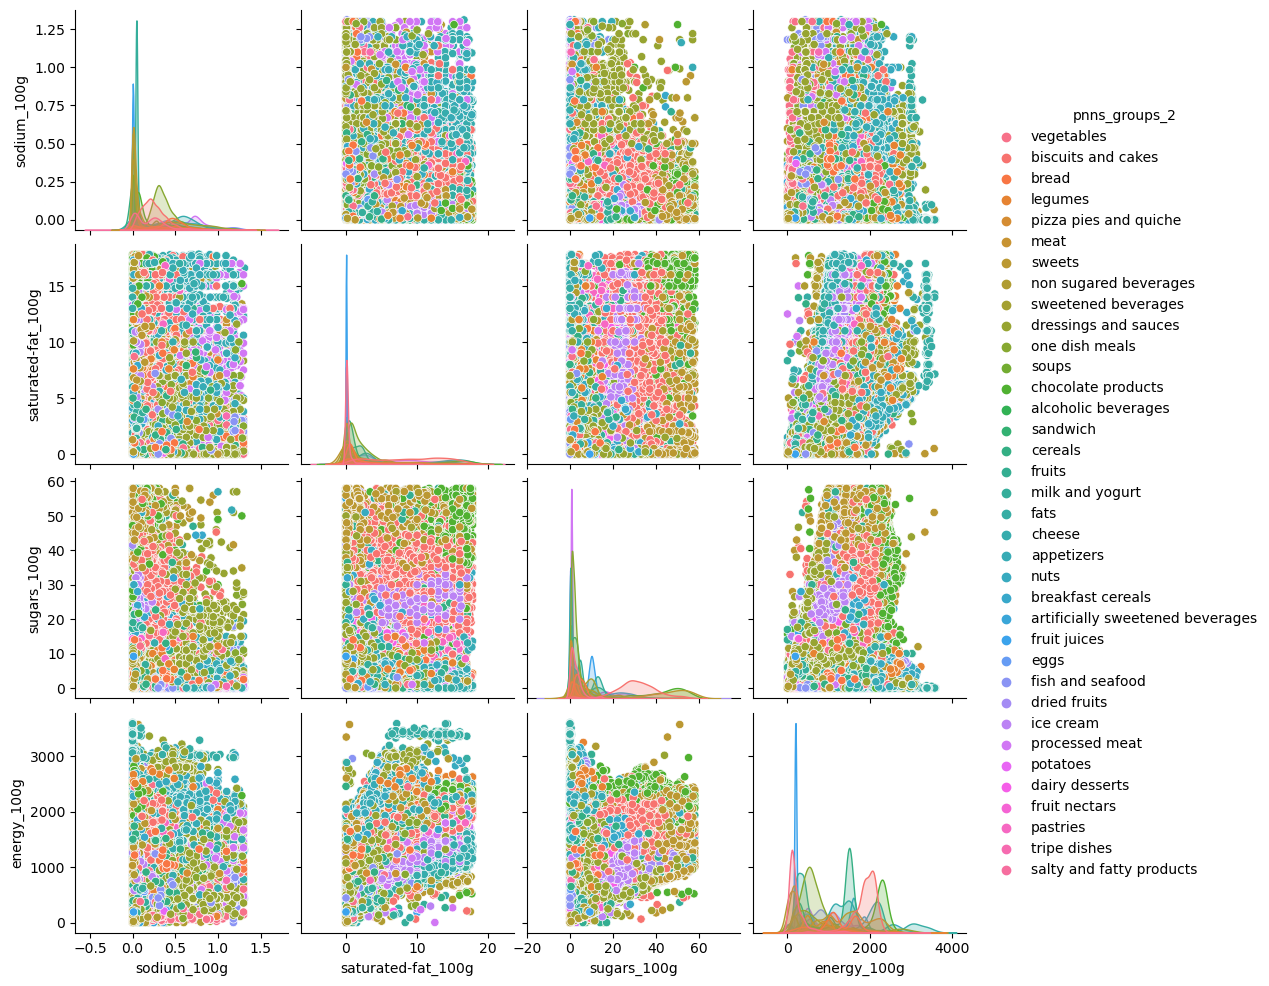

In [22]:
sns.pairplot(data=data_cleaned[['sodium_100g', 'saturated-fat_100g', 'sugars_100g','energy_100g', 'pnns_groups_2']],hue='pnns_groups_2')

In [23]:
imp = IterativeImputer(max_iter=10, random_state=0,verbose=True)
imp.fit(data_cleaned[numCol])
# the model learns that the second feature is double the first
data_cleaned.loc[:,numCol] = np.round(imp.transform(data_cleaned[numCol]))

[IterativeImputer] Completing matrix with shape (316836, 20)
[IterativeImputer] Change: 1804.394183997561, scaled tolerance: 9980282863.788 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (316836, 20)


In [24]:
compute_nb_mising_values(data_cleaned)

Taux de valeurs non nulles  \
code                                                         100.00   
cholesterol_100g                                             100.00   
unité                                                        100.00   
fiber_100g                                                   100.00   
proteins_100g                                                100.00   
sodium_100g                                                  100.00   
vitamin-a_100g                                               100.00   
vitamin-c_100g                                               100.00   
saturated-fat_100g                                           100.00   
calcium_100g                                                 100.00   
fruits-vegetables-nuts_100g                                  100.00   
nutrition-score-fr_100g                                      100.00   
bocal/conserve                                               100.00   
creme/sauce                                                  100.00   
litre                                                        100.00   
petit pot/yaourt                                             100.00   
poids                                                        100.00   
iron_100g                                                    100.00   
energy_100g                                                  100.00   
sugars_100g                                                  100.00   
estimatedNS                                                  100.00   
last_modified_t                                              100.00   
created_t                                                    100.00   
url                                                          100.00   
creator                                                      100.00   
states_tags                                                   99.99   
countries_fr                                                  99.92   
product_name                                                  94.43   
brands_tags                                                   91.14   
unites_abb                                                    84.79   
unites                                                        84.79   
salt_100g                                                     79.55   
additives_n                                                   77.45   
ingredients_text                                              77.45   
ingredients_from_palm_oil_n                                   77.45   
ingredients_that_may_be_from_palm_oil_n                       77.45   
fat_100g                                                      75.87   
carbohydrates_100g                                            75.78   
nutrition_grade_fr                                            68.96   
nutrition-score-uk_100g                                       68.96   
serving_size                                                  65.61   
additives_tags                                                48.11   
trans-fat_100g                                                44.41   
quantity                                                      32.96   
categories_tags                                               26.55   
main_category_fr                                              26.54   
packaging_tags                                                24.83   
image_small_url                                               23.87   
image_url                                                     23.87   
pnns_groups_2                                                 22.62   
pnns_groups_1                                                 21.68   
purchase_places                                               18.29   
generic_name                                                  16.59   
stores                                                        16.25   
labels_tags                                                   14.67   
manufacturing_places_tags                                     11.

In [25]:
data_cleaned[numCol].describe()

code  nutrition-score-fr_100g    energy_100g  \
count  3.168360e+05            316836.000000  316836.000000   
mean   2.211999e+12                 8.913753    1110.452966   
std    2.645375e+12                 7.828231     707.242384   
min    7.580000e+02               -15.000000    -231.000000   
25%    5.840030e+10                 3.000000     502.000000   
50%    8.123150e+11                 9.000000    1129.000000   
75%    3.560070e+12                14.000000    1569.000000   
max    9.980283e+12                38.000000    3615.000000   

       saturated-fat_100g  cholesterol_100g    sugars_100g     fiber_100g  \
count       316836.000000          316836.0  316836.000000  316836.000000   
mean             3.756884               0.0      13.032023       1.877605   
std              4.037348               0.0      13.514945       1.892350   
min             -2.000000               0.0     -31.000000      -4.000000   
25%              0.000000               0.0       2.000000       0.000000   
50%              3.000000               0.0      11.000000       2.000000   
75%              5.000000               0.0      17.000000       2.000000   
max             18.000000               0.0      58.000000       9.000000   

       proteins_100g    sodium_100g  vitamin-a_100g  vitamin-c_100g  \
count  316836.000000  316836.000000        316836.0        316836.0   
mean        6.031344       0.191313             0.0             0.0   
std         5.351739       0.393336             0.0             0.0   
min        -5.000000       0.000000             0.0             0.0   
25%         2.000000       0.000000             0.0             0.0   
50%         6.000000       0.000000             0.0             0.0   
75%         8.000000       0.000000             0.0             0.0   
max        24.000000       1.000000             0.0             0.0   

       calcium_100g  iron_100g  fruits-vegetables-nuts_100g  bocal/conserve  \
count      316836.0   316836.0                316836.000000   316836.000000   
mean            0.0        0.0                    31.433170        0.001619   
std             0.0        0.0                     9.577585        0.040206   
min             0.0        0.0                   -48.000000        0.000000   
25%             0.0        0.0                    31.000000        0.000000   
50%             0.0        0.0                    31.000000        0.000000   
75%             0.0        0.0                    32.000000        0.000000   
max             0.0        0.0                   100.000000        1.000000   

         creme/sauce          litre  petit pot/yaourt          poids  \
count  316836.000000  316836.000000     316836.000000  316836.000000   
mean        0.000199       0.125999          0.000098       0.718924   
std         0.014100       0.331849          0.009891       0.449525   
min         0.000000       0.000000          0.000000       0.000000   
25%         0.000000       0.000000          0.000000       0.000000   
50%         0.000000       0.000000          0.000000       1.000000   
75%         0.000000       0.000000          0.000000       1.000000   
max         1.000000       1.000000          1.000000       1.000000   

               unité  
count  316836.000000  
mean        0.001026  
std         0.032011  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

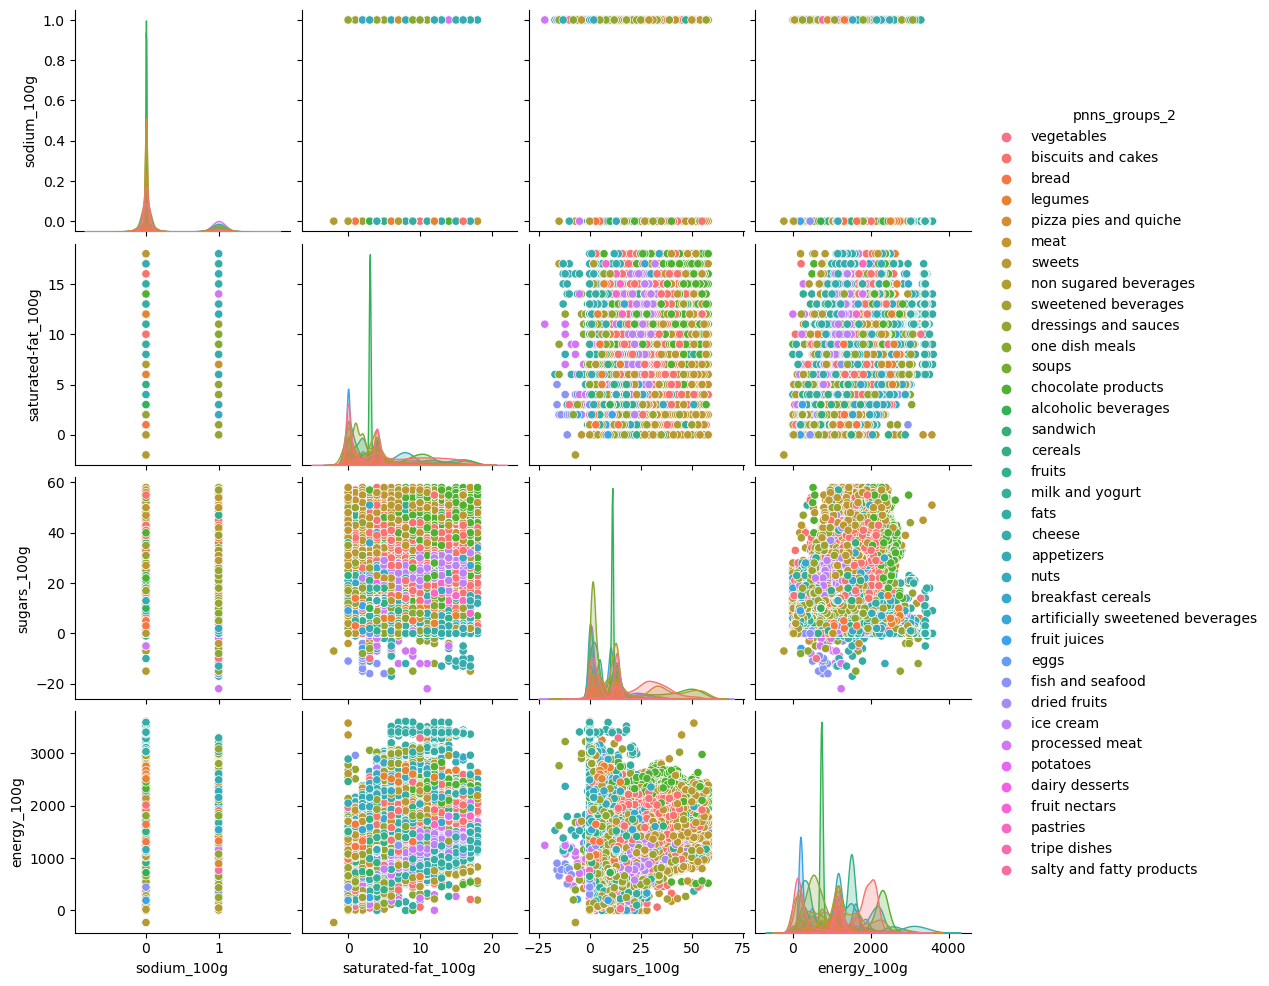

In [26]:
sns.pairplot(data=data_cleaned[['sodium_100g', 'saturated-fat_100g', 'sugars_100g','energy_100g', 'pnns_groups_2']],hue='pnns_groups_2')

<div class="alert alert-block alert-info">
    Comme on le voit les colonnes numeriques de notre dataset ne possèdent plus de données manquantes.
</div>

### Données qualitatives

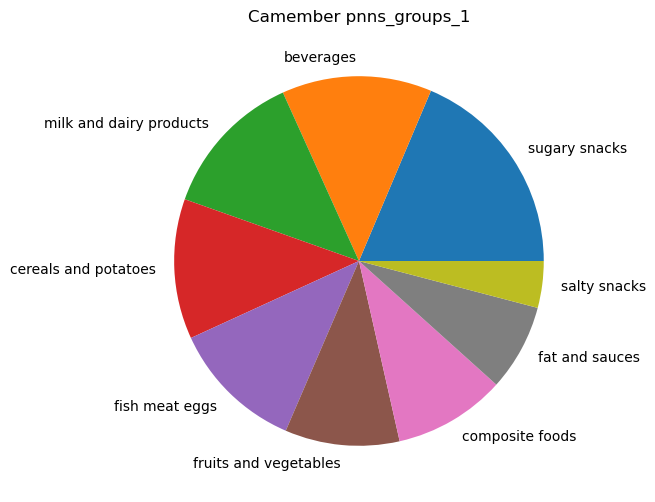

In [27]:
# pie plot
fig, axes = plt.subplots( figsize=(12, 6) )

axes.set_title('Camember pnns_groups_1')
data_cleaned.pnns_groups_1.value_counts().plot(kind='pie',ax = axes,label = '');


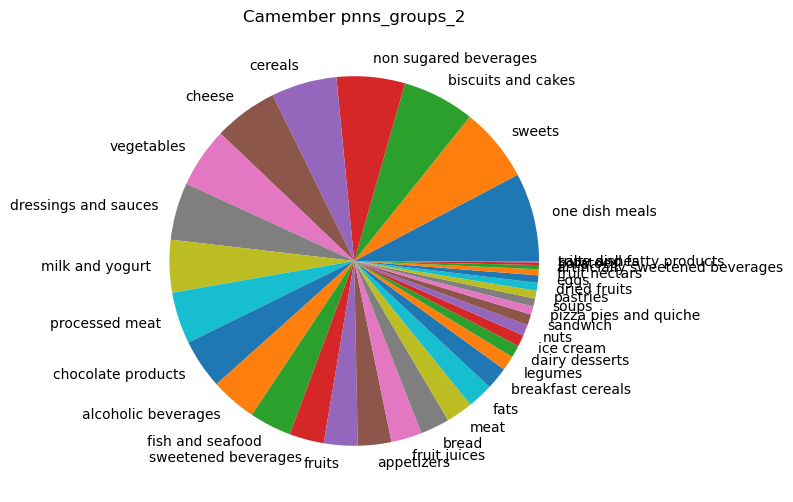

In [28]:
# pie plot
fig, axes = plt.subplots(figsize=(12, 6) )

axes.set_title('Camember pnns_groups_2')
data_cleaned.pnns_groups_2.value_counts().plot(kind='pie',ax =  axes,label = '');

In [29]:
data_cleaned[['pnns_groups_1','pnns_groups_2']].value_counts()

pnns_groups_1            pnns_groups_2                   
composite foods          one dish meals                      5536
sugary snacks            sweets                              4673
                         biscuits and cakes                  4525
beverages                non sugared beverages               4285
cereals and potatoes     cereals                             4107
milk and dairy products  cheese                              4018
fruits and vegetables    vegetables                          3768
fat and sauces           dressings and sauces                3595
milk and dairy products  milk and yogurt                     3292
fish meat eggs           processed meat                      3245
sugary snacks            chocolate products                  3105
fish meat eggs           fish and seafood                    2632
beverages                sweetened beverages                 2167
fruits and vegetables    fruits                              2114
salty snacks      

array([<AxesSubplot:title={'center':'Nbgp1'}>,
       <AxesSubplot:title={'center':'Nbgp1_2'}>], dtype=object)

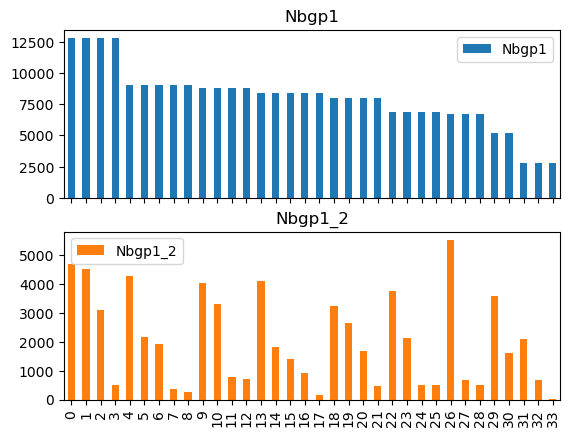

In [30]:
#fig, axes = plt.subplots(figsize=(20,10))
pd.merge(left=data_cleaned[['pnns_groups_1']].value_counts().reset_index().rename(columns={0:'Nbgp1'}),
         right=data_cleaned[['pnns_groups_1','pnns_groups_2']].value_counts().reset_index().rename(columns={0:'Nbgp1_2'}),
         on = 'pnns_groups_1',
         how = 'inner').plot.bar( subplots=True)

### le rapport de corrélation

In [31]:
def rapport_corr(x,yquanti):
    '''
    x est une variable qualitative
    yquanti est une variable quantitative
    '''
    tmp = pd.DataFrame({'x':data_cleaned[x],'y':data_cleaned[yquanti]}).reset_index()[['x','y']]
    tmp['y'] = tmp['y'].fillna(0)
    tmp.dropna(inplace=True)

    somme = 0
    for facteur in tmp.x.value_counts().index:
        ind = tmp.x[tmp.x == facteur].dropna(axis=0).index
        classe = tmp.y[ind]
        somme = somme + len(classe)*np.sum((np.mean(classe)-np.mean(tmp.y))**2)
    y_ecart = np.sum((tmp.y-np.mean(tmp.y))**2)
    rc = somme/y_ecart
    #rc.index = ['Rapport de Correlation']
    return rc

In [32]:
# modelisation de pnns_groups_2

In [33]:
import warnings
warnings.filterwarnings("ignore")

rapport_corré = dict()
for col in data_cleaned[colgarder].select_dtypes(include=[np.number]).columns.tolist():
    #print(col,'  ',rapport_corr(x = data_cleaned.pnns_groups_2,yquanti = col))
    rapport_corré[col] = rapport_corr(x = 'pnns_groups_2',yquanti = col)
    
rapport_corré = pd.DataFrame.from_dict(rapport_corré,orient='index',columns=['RapportCorrélation'])\
.sort_values(by = 'RapportCorrélation',ascending=False)

rapport_corré = rapport_corré.reset_index().merge(right = compute_nb_mising_values(data_cleaned).reset_index(),
                                  how = 'left',right_on = 'index',left_on ='index')
rapport_corré.rename(columns={'index':'Colonnes'},inplace=True)

In [34]:
rapport_corré.sort_values(by = ['RapportCorrélation'],ascending = False).style.background_gradient(cmap='Blues')

</br>

</br>

</br>

</br>

</br>

</br>

</br>

#### les colonnes conservées

In [35]:
data_cleaned[colgarder].drop(columns=['code', 'product_name', 'quantity', 'serving_size', 'nutrition_grade_fr',
                                         'pnns_groups_1','nutrition_grade_fr']).columns

Index(['categories_tags', 'pnns_groups_2', 'nutrition-score-fr_100g',
       'energy_100g', 'saturated-fat_100g', 'cholesterol_100g', 'sugars_100g',
       'fiber_100g', 'proteins_100g', 'sodium_100g', 'vitamin-a_100g',
       'vitamin-c_100g', 'calcium_100g', 'iron_100g',
       'fruits-vegetables-nuts_100g', 'bocal/conserve', 'creme/sauce', 'litre',
       'petit pot/yaourt', 'poids', 'unité'],
      dtype='object')

## Reduction de dimension 

In [36]:
import functions_display_PCA

In [37]:
from sklearn import preprocessing as prep

X = data_cleaned[colgarder].drop(columns=['code', 'product_name', 'quantity', 'serving_size', 'nutrition_grade_fr',
                                         'pnns_groups_1','categories_tags','nutrition_grade_fr']).dropna().drop(columns='pnns_groups_2')

y = data_cleaned[colgarder].drop(columns=['code', 'product_name', 'quantity', 'serving_size', 'nutrition_grade_fr',
                                         'pnns_groups_1', 'categories_tags','nutrition_grade_fr']).dropna().pnns_groups_2


# Centrage reduction - scaling step
std_scale = prep.StandardScaler()
X_scaled = std_scale.fit_transform(X)

### Kernel ACP

In [38]:
%%time
from sklearn.decomposition import KernelPCA
# KernelPCA
from sklearn.model_selection import train_test_split
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(X_scaled,y, 
                                                    test_size = 0.7, # 1% du jeux de données réservé pour test la qualité du model
                                                    random_state = 0)
kpca = KernelPCA(gamma = 1, kernel='rbf')
X_kpca = kpca.fit(X_scaled_train)

#% de variabilité expliqué par axes
len(kpca.eigenvalues_/np.sum(kpca.eigenvalues_))

Wall time: 19min 41s


14072

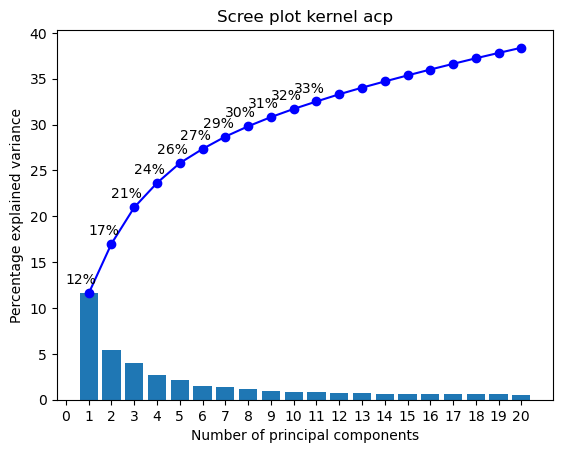

In [39]:
scree = kpca.eigenvalues_[:20]*100/np.sum(kpca.eigenvalues_)
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="blue",marker='o')

for i in np.arange(len(scree)-9):
    plt.text(i, scree.cumsum()[i]+1,s =str(round(scree.cumsum()[i]))+'%')   
plt.xlabel("Number of principal components")
plt.ylabel("Percentage explained variance")
plt.title("Scree plot kernel acp")
plt.xticks(np.arange(len(scree)+1))
plt.show(block=False)

In [40]:
X_KPCA = kpca.transform(X_scaled)

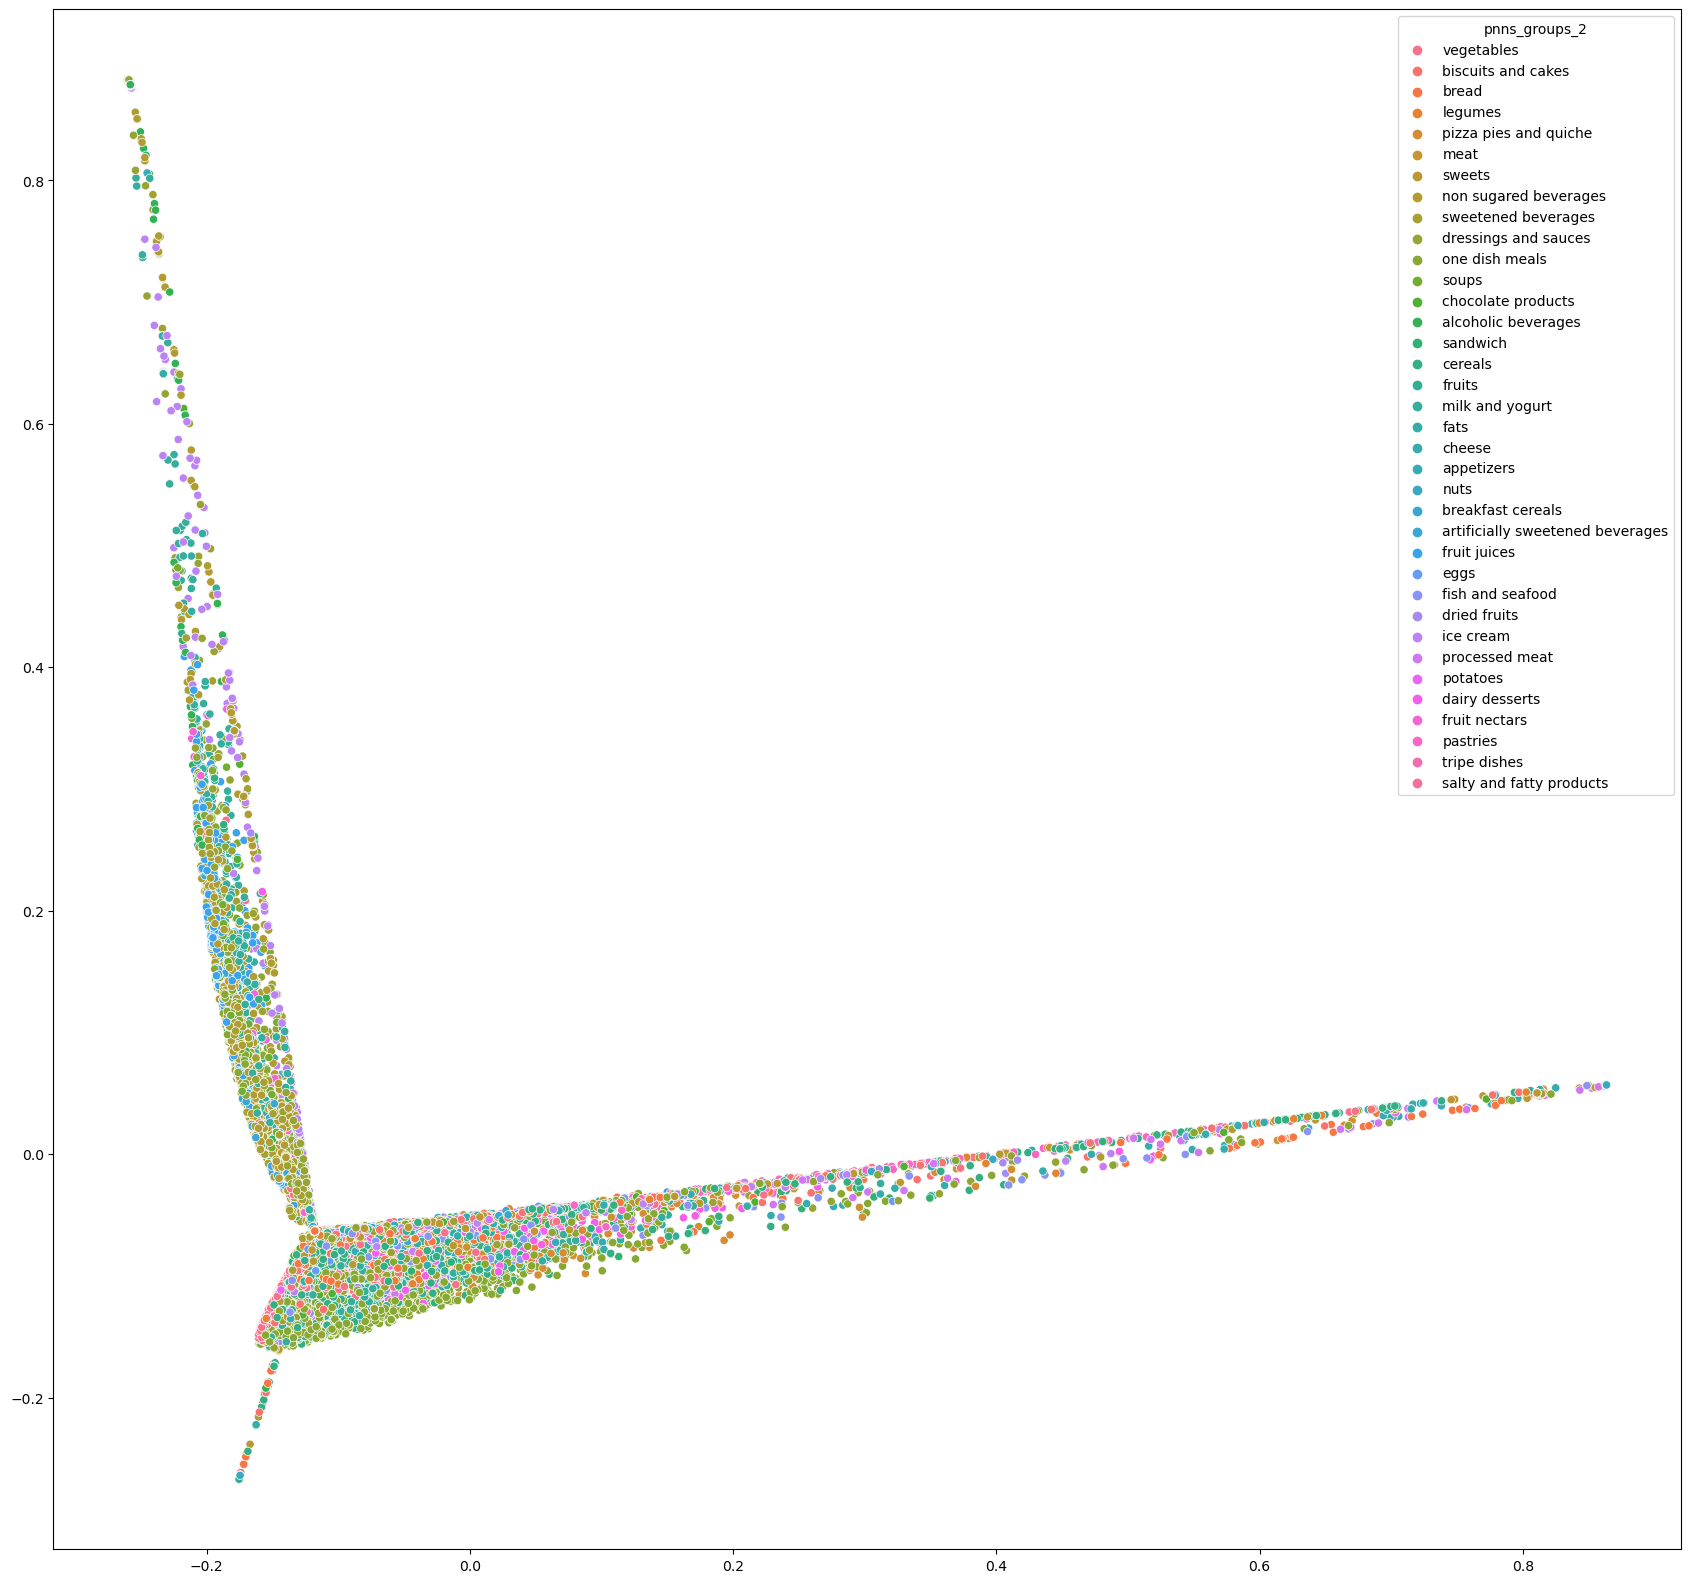

In [41]:
fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize=(21,20))
sns.scatterplot(X_KPCA[:,0],X_KPCA[:,1],hue=y,ax=axes );

In [42]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

resultKNN_mean = []
knnKPCA = KNeighborsClassifier(n_neighbors = 5)
resultKNNKPCA = cross_val_score(knnKPCA, X_KPCA[:,:1000], y,  scoring='accuracy')
# report the mean performance
print('Accuracy: %.3f' % resultKNNKPCA.mean())

Accuracy: 0.570
Wall time: 47.1 s


### ACP

In [43]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis


# Principal Component Analysis
pca = PCA()
X_r = pca.fit(X_scaled).transform(X_scaled)

# LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_r2 = lda.fit(X_scaled, y).transform(X_scaled)

# QuadraticDiscriminantAnalysis
Qda = QuadraticDiscriminantAnalysis()
Qda.fit(X_scaled, y)

# Percentage of variance explained for each components
print(
    "explained variance ratio (all components): %s"
    % str(pca.explained_variance_ratio_)
)
#pd.DataFrame({'Variance expliqué':pca.explained_variance_ratio_*100}).plot(kind='bar');

explained variance ratio (all components): [2.28232215e-01 1.41197797e-01 1.03485287e-01 7.29244857e-02
 7.24586871e-02 7.16305744e-02 7.14323938e-02 6.98022018e-02
 5.61182277e-02 3.99757337e-02 3.19368421e-02 1.92269330e-02
 1.50663432e-02 6.51227908e-03 5.81423505e-34 8.80444060e-35
 8.24532336e-35 2.86943573e-35 1.26999048e-36]


#### Selection du nombre d'axe d'ACP à conserver

- Regle de Kaiser en ACP normé: Conserver axes ssi λ > 1

In [44]:
print("Nombre d'axes conservés avec cette méthode: ",np.sum(pca.explained_variance_>1) )

Nombre d'axes conservés avec cette méthode:  7


- ébouli des valeurs propes

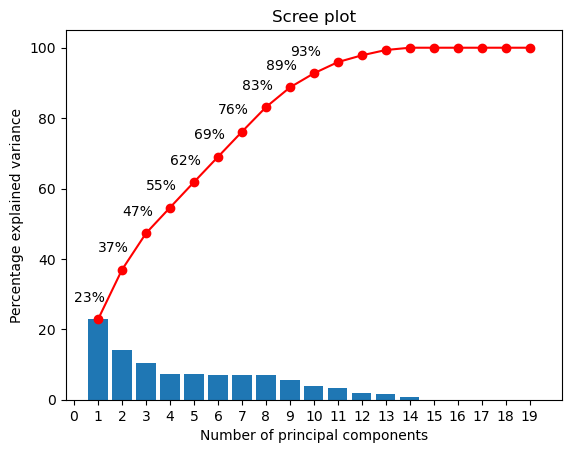

In [45]:
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')

for i in np.arange(len(scree)-9):
    plt.text(i, scree.cumsum()[i]+5,s =str(round(scree.cumsum()[i]))+'%')   
plt.xlabel("Number of principal components")
plt.ylabel("Percentage explained variance")
plt.title("Scree plot")
plt.xticks(np.arange(len(scree)+1))
plt.show(block=False)

- Règle conserver axes ssi:
 $λ< (100/p)$ </br>
 Cette valeur représente la variabilité d'une variable brute apres centrage reduction.

In [46]:
print("Nombre d'axes conservés avec cette méthode: {}.\nCe qui représente {:.2%} des colonnes du début".format(np.sum(pca.explained_variance_*100<(100/X_scaled.shape[1])),
                                                                                                               np.sum(pca.explained_variance_*100<(100/X_scaled.shape[1]))/X_scaled.shape[1]) 
     )

Nombre d'axes conservés avec cette méthode: 5.
Ce qui représente 26.32% des colonnes du début


''

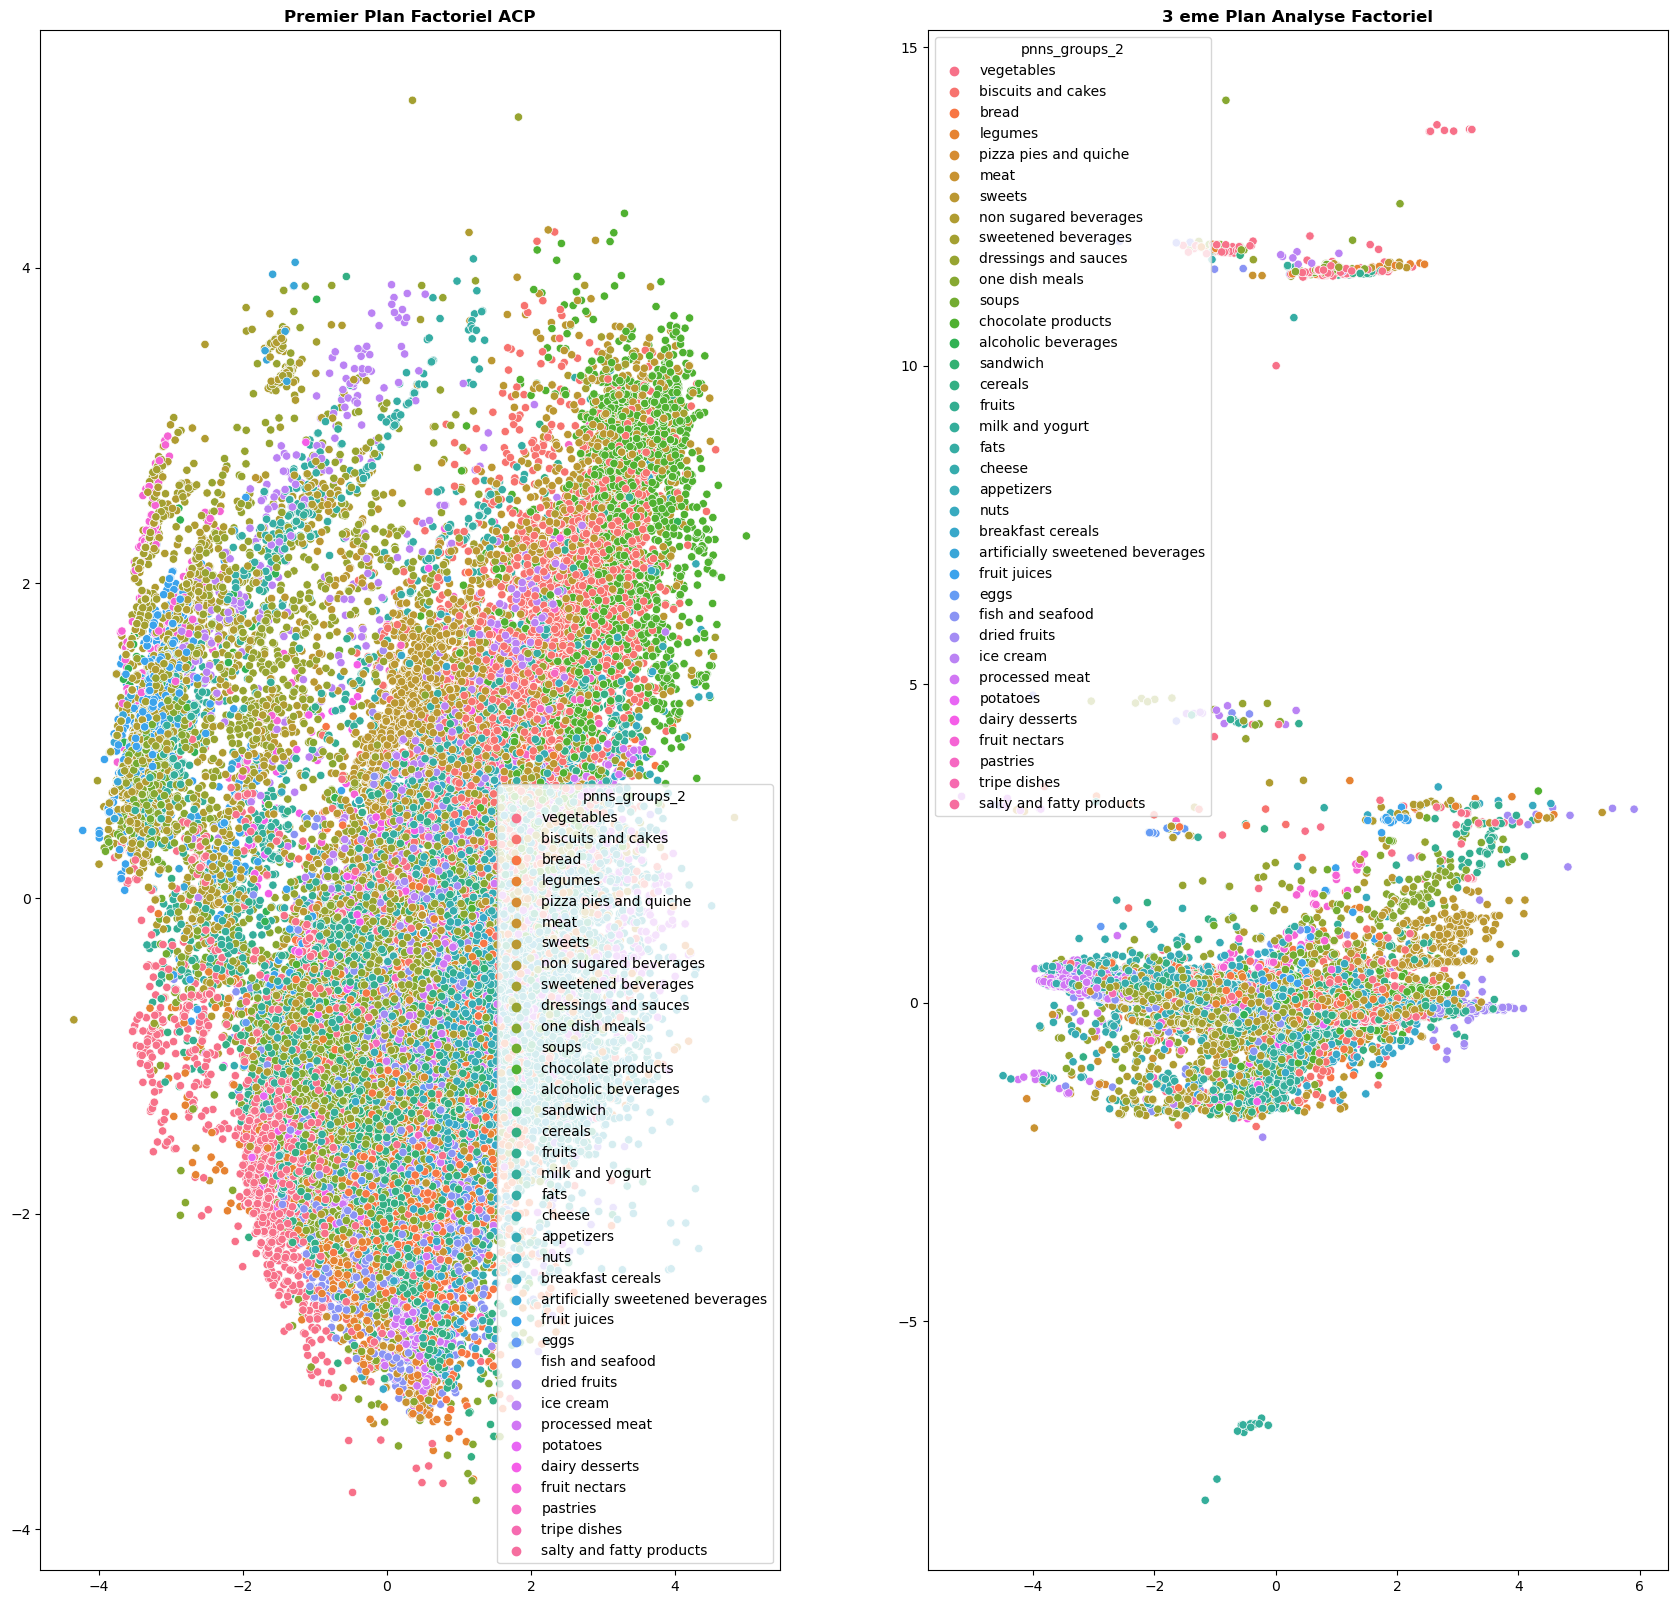

In [47]:
import warnings
warnings.filterwarnings("ignore")
fig,axes = plt.subplots(nrows = 1,ncols = 2,figsize=(21,20))
sns.scatterplot(X_r[:,0],X_r[:,1],hue=y,ax = axes[0])
sns.scatterplot(X_r[:,2],X_r[:,3],hue=y,ax = axes[1])
#sns.scatterplot(X_r2[:,0],X_r2[:,1],hue=y,ax = axes[1])
#sns.scatterplot(X_kpca[:,0],X_kpca[:,1],hue=y_scaled_train,ax = axes[2])
axes[0].set_title('Premier Plan Factoriel ACP', fontweight ="bold")
axes[1].set_title('3 eme Plan Analyse Factoriel', fontweight ="bold")
;

</br>

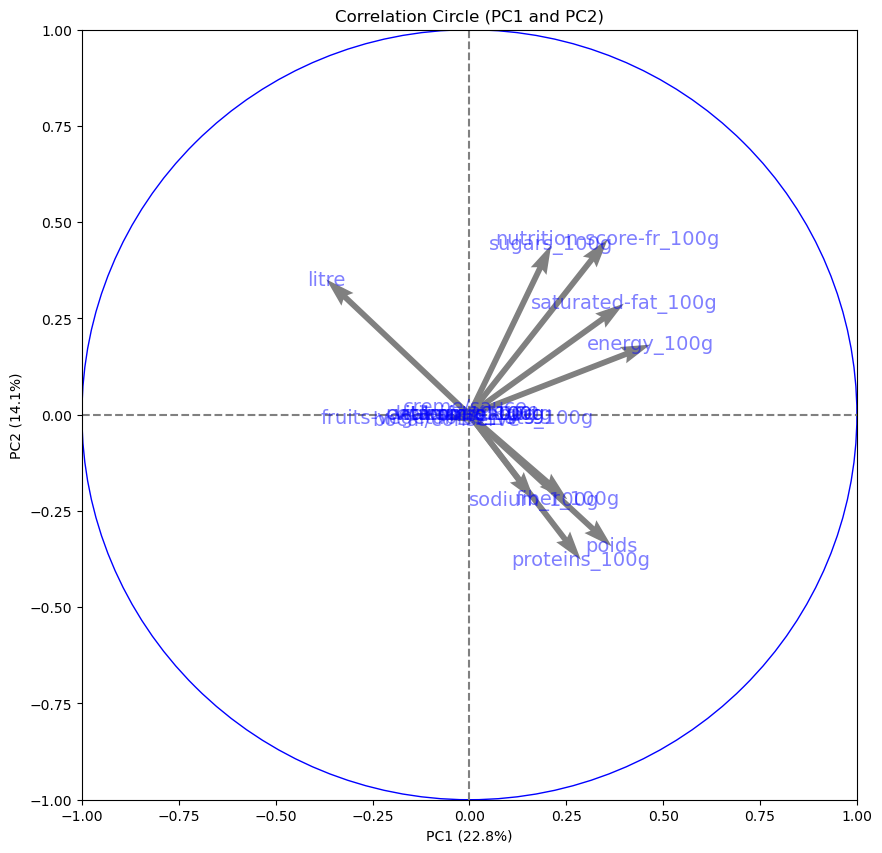

In [48]:
# Generate a correlation circle
pcs = pca.components_ 
functions_display_PCA.display_circles(pcs, 19, pca=pca, axis_ranks=[(0,1)], labels = np.array(X.columns),) 

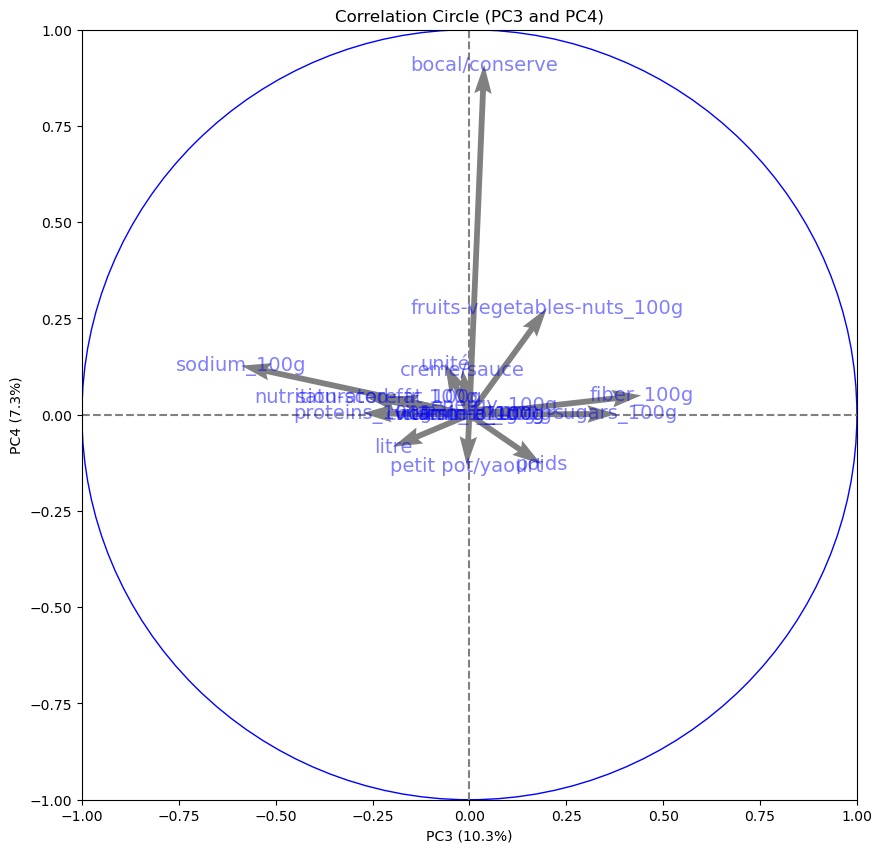

In [49]:
# Generate a correlation circle
pcs = pca.components_ 
functions_display_PCA.display_circles(pcs, 19, pca=pca, axis_ranks=[(2,3)], labels = np.array(X.columns),) 

## Imputation de la variable cible pnns_groups_2

### LDA

In [50]:
### LDA
from sklearn.model_selection import cross_val_score
resultLDA = cross_val_score(lda, data_cleaned[['nutrition-score-fr_100g','energy_100g', 'saturated-fat_100g', 
                                               'cholesterol_100g', 'sugars_100g','fiber_100g', 'proteins_100g', 
                                               'sodium_100g', 'vitamin-a_100g','vitamin-c_100g', 'calcium_100g', 
                                               'iron_100g', 'fruits-vegetables-nuts_100g', 'bocal/conserve', 
                                               'creme/sauce', 'litre','petit pot/yaourt', 'poids', 'unité','pnns_groups_2']]\
                            .loc[data_cleaned.pnns_groups_2.notna()].drop(columns=["pnns_groups_2"]), 
                            data_cleaned.loc[data_cleaned.pnns_groups_2.notna()].pnns_groups_2,  scoring='accuracy')
# report the mean performance
print('Accuracy: %.3f' % resultLDA.mean())

Accuracy: 0.405


### ACP

{3: [0.48076958266687564, 0.5065036306301711, 0.5125740611026652, 0.5489564232652377, 0.5739366420559581], 5: [0.4978788948494618, 0.5160769033667599, 0.5231943099292351, 0.5545802995962469, 0.5776488304611361], 7: [0.49974896769537513, 0.5197054243991287, 0.5237246492670704, 0.5609999512541615, 0.5790025557581406]}
Wall time: 51.8 s


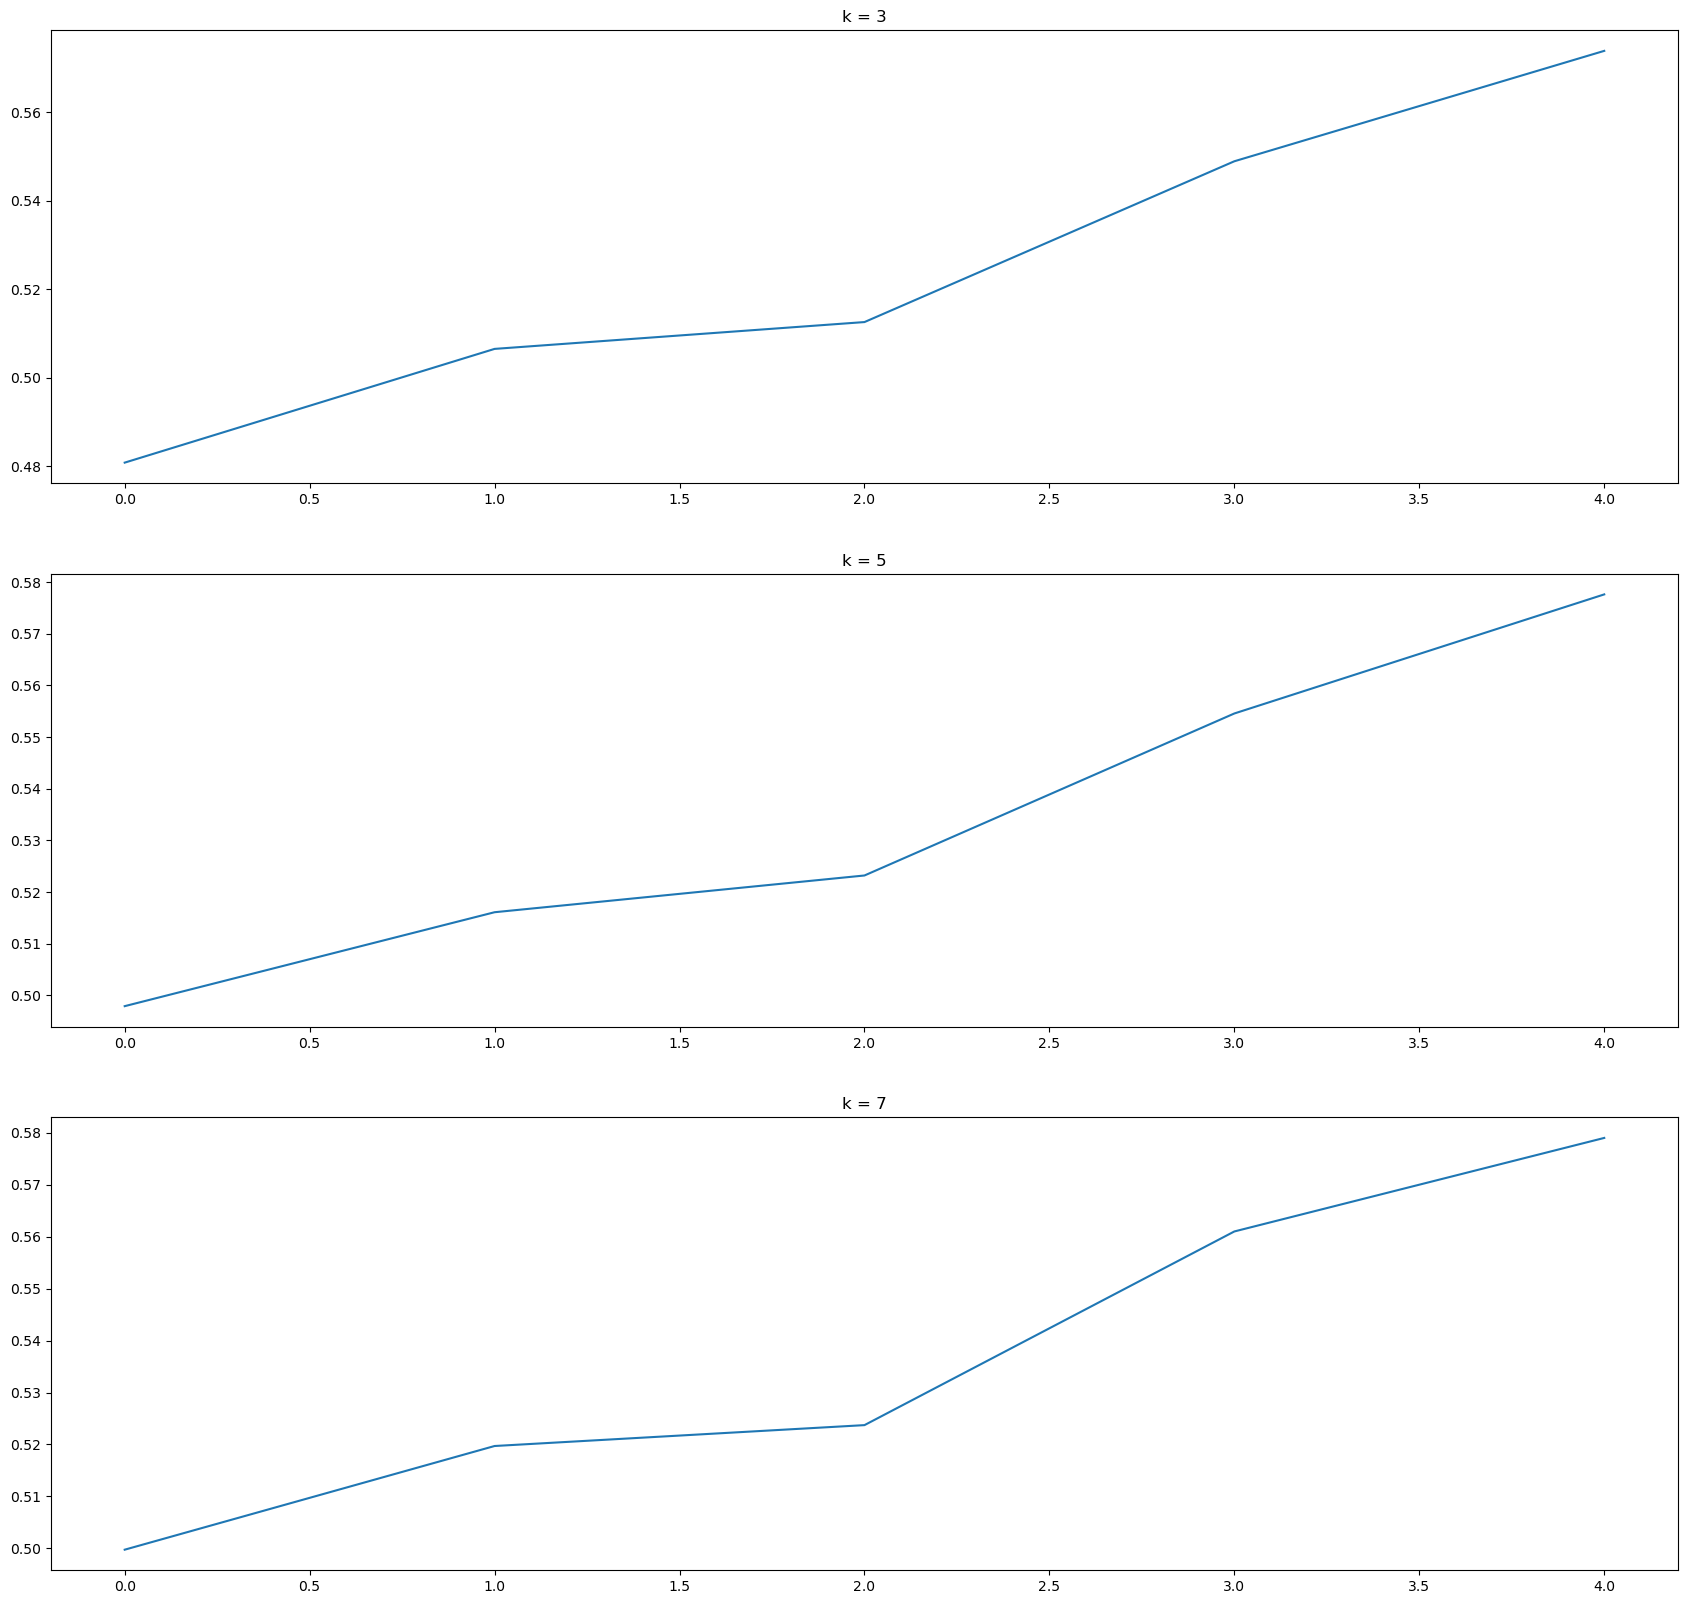

In [51]:
%%time
from sklearn.model_selection import cross_val_score
resultat_total = dict()
fig,axes = plt.subplots(nrows = 3,ncols = 1,figsize=(21,20))
for i,k in enumerate([3,5,7]):
    resultKNN_mean = []
    for ncol in [3,5,7,11,19]:
        knn3 = KNeighborsClassifier(n_neighbors = k)
        resultKNN = cross_val_score(knn3, X_r[:,:ncol], y,  scoring='accuracy').mean()
        # report the mean performance
        resultKNN_mean.append(resultKNN)
    sns.lineplot(range(len(resultKNN_mean)),resultKNN_mean,ax = axes[i])
    text_titre = 'k = ' + str(k) 
    axes[i].set_title(text_titre)
    resultat_total[k] = resultKNN_mean

print(resultat_total)

In [59]:
%%time
resultKNN_mean = []
knnb = KNeighborsClassifier(n_neighbors = 7)
resultKNN = cross_val_score(knnb, X_r[:,:19], y,  scoring='accuracy')
# report the mean performance
print('Accuracy: %.3f' % resultKNN.mean())

Accuracy: 0.579
Wall time: 4.04 s


### LDA

{3: [0.461580430838039, 0.5607068043367555, 0.5806631909306332, 0.5777325309413869, 0.5789327263220303], 5: [0.47554989366376743, 0.5721224409384182, 0.586608252286804, 0.5835101397283979, 0.5841241990214492], 7: [0.482876596706164, 0.5741460407794481, 0.5912694440732841, 0.5853662733677919, 0.586524593677729]}
Wall time: 1min 3s


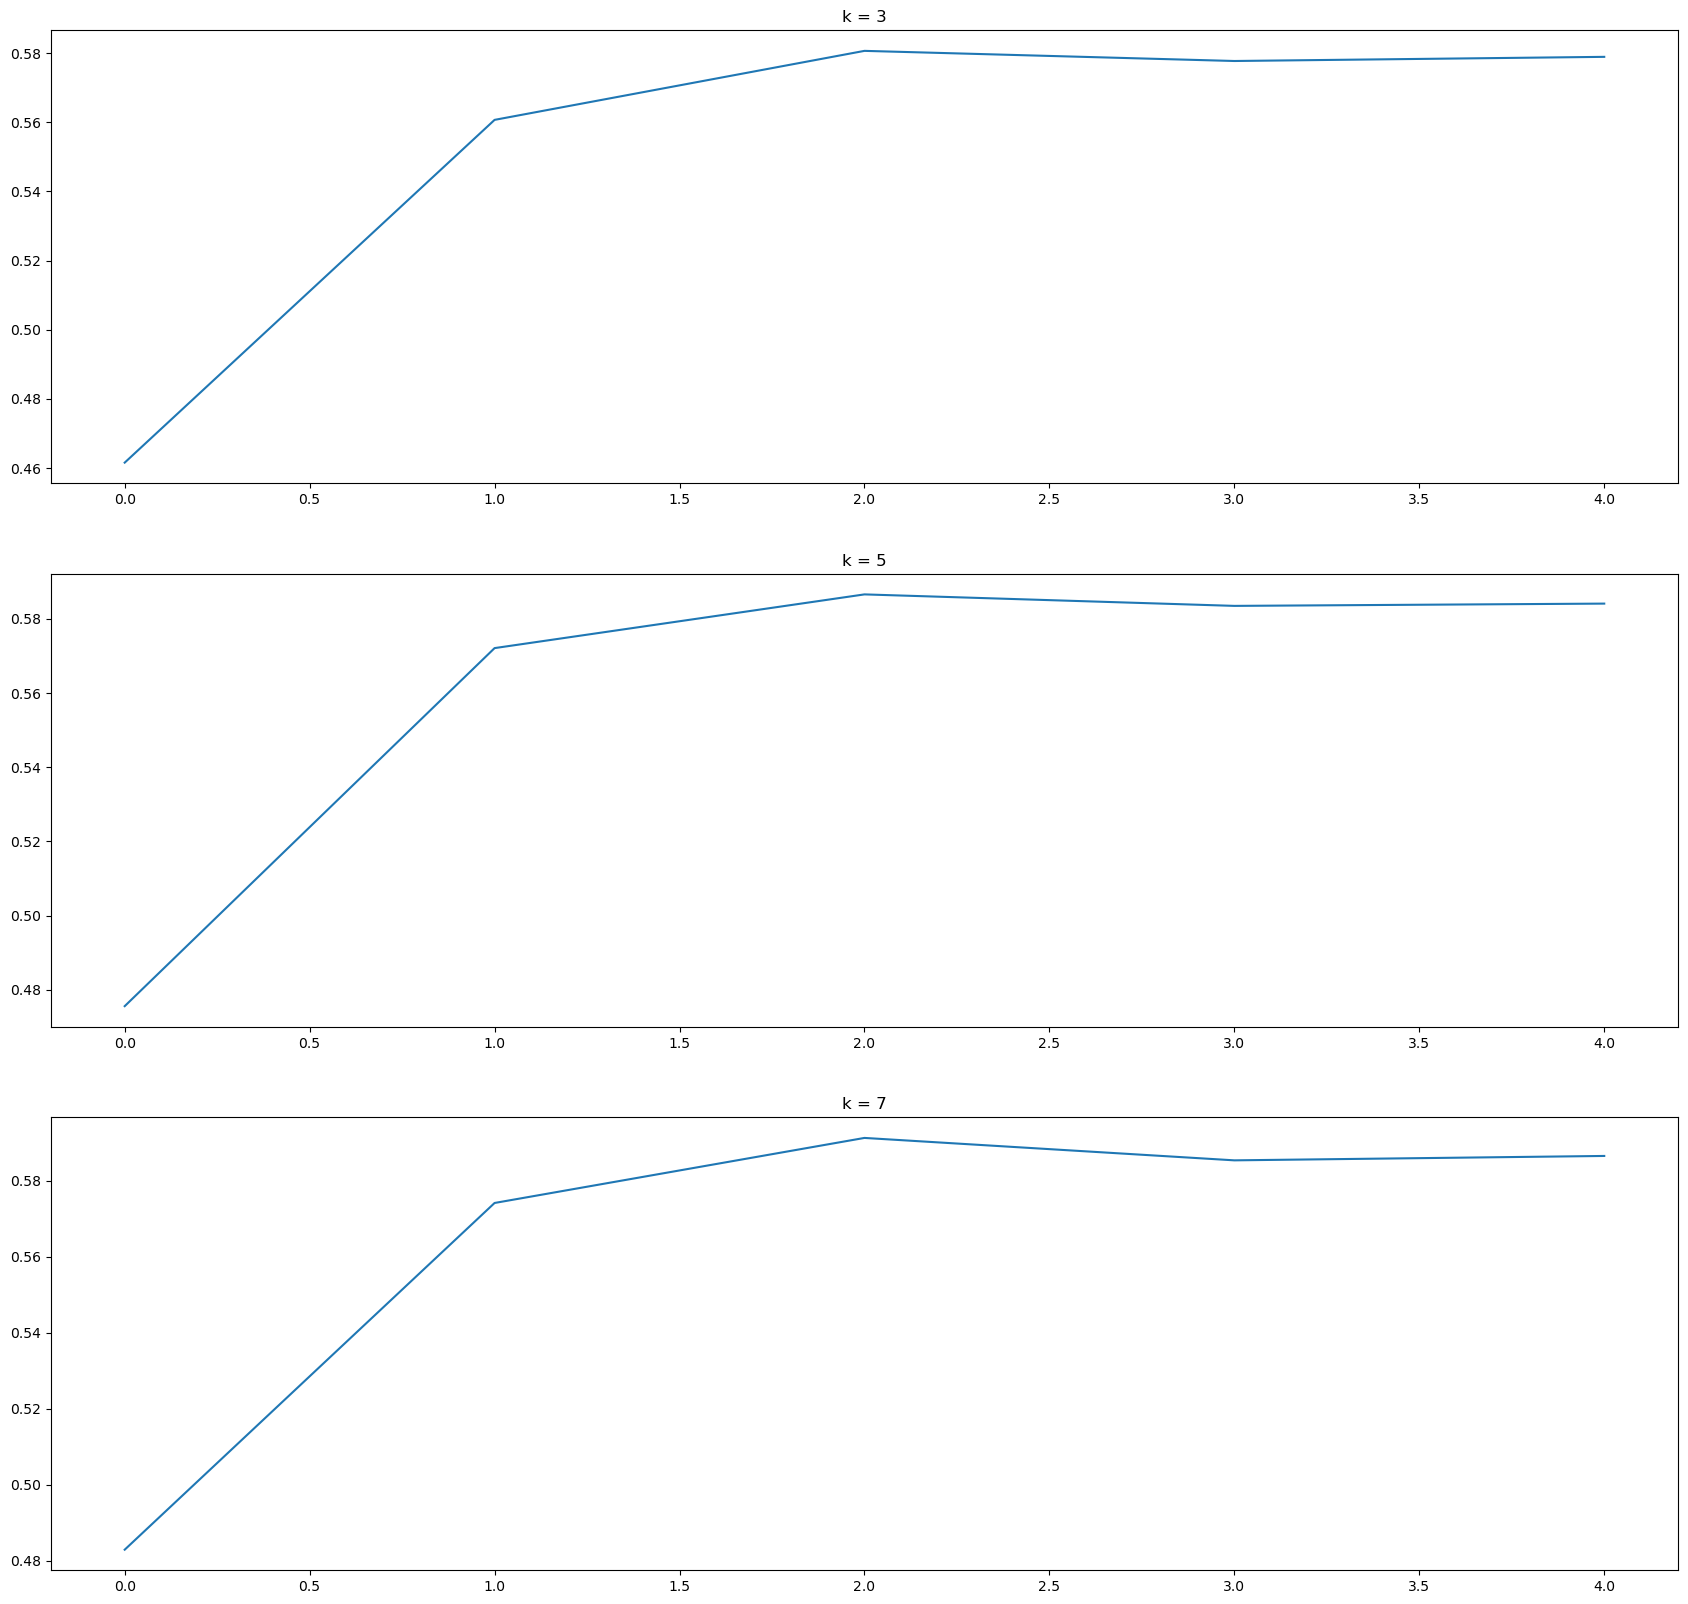

In [53]:
%%time
from sklearn.model_selection import cross_val_score
resultat_total = dict()
fig,axes = plt.subplots(nrows = 3,ncols = 1,figsize=(21,20))
for i,k in enumerate([3,5,7]):
    resultKNN_mean = []
    for ncol in [3,5,7,11,19]:
        knn = KNeighborsClassifier(n_neighbors = k)
        resultKNN = cross_val_score(knn, X_r2[:,:ncol], y,  scoring='accuracy').mean()
        # report the mean performance
        resultKNN_mean.append(resultKNN)
    sns.lineplot(range(len(resultKNN_mean)),resultKNN_mean,ax = axes[i])
    text_titre = 'k = ' + str(k) 
    axes[i].set_title(text_titre)
    resultat_total[k] = resultKNN_mean

print(resultat_total)

In [66]:
%%time
resultKNN_mean = []
knnlda = KNeighborsClassifier(n_neighbors = 7)
resultKNNlda = cross_val_score(knnlda, X_r2[:,:7], y,  scoring='accuracy')
# report the mean performance
print('Accuracy: %.3f' % resultKNNlda.mean())

Accuracy: 0.591
Wall time: 3.64 s


In [55]:
X_scaled.shape

(71656, 19)

### kernel ACP

{3: [0.3243413600766675, 0.3584069345833768, 0.4029813844842522, 0.4508905512200063, 0.48314183210309, 0.5541061377437431, 0.5622980248899017], 5: [0.3250530113428236, 0.36177016374141974, 0.4120800493916284, 0.45330481984167126, 0.4860027152386327, 0.5624791868609886, 0.5697639817252377], 7: [0.3228062770851733, 0.3601931959417366, 0.4115497266075138, 0.45439337206163904, 0.48692383436440617, 0.5645586126642235, 0.5726109831054091]}
Wall time: 4min 10s


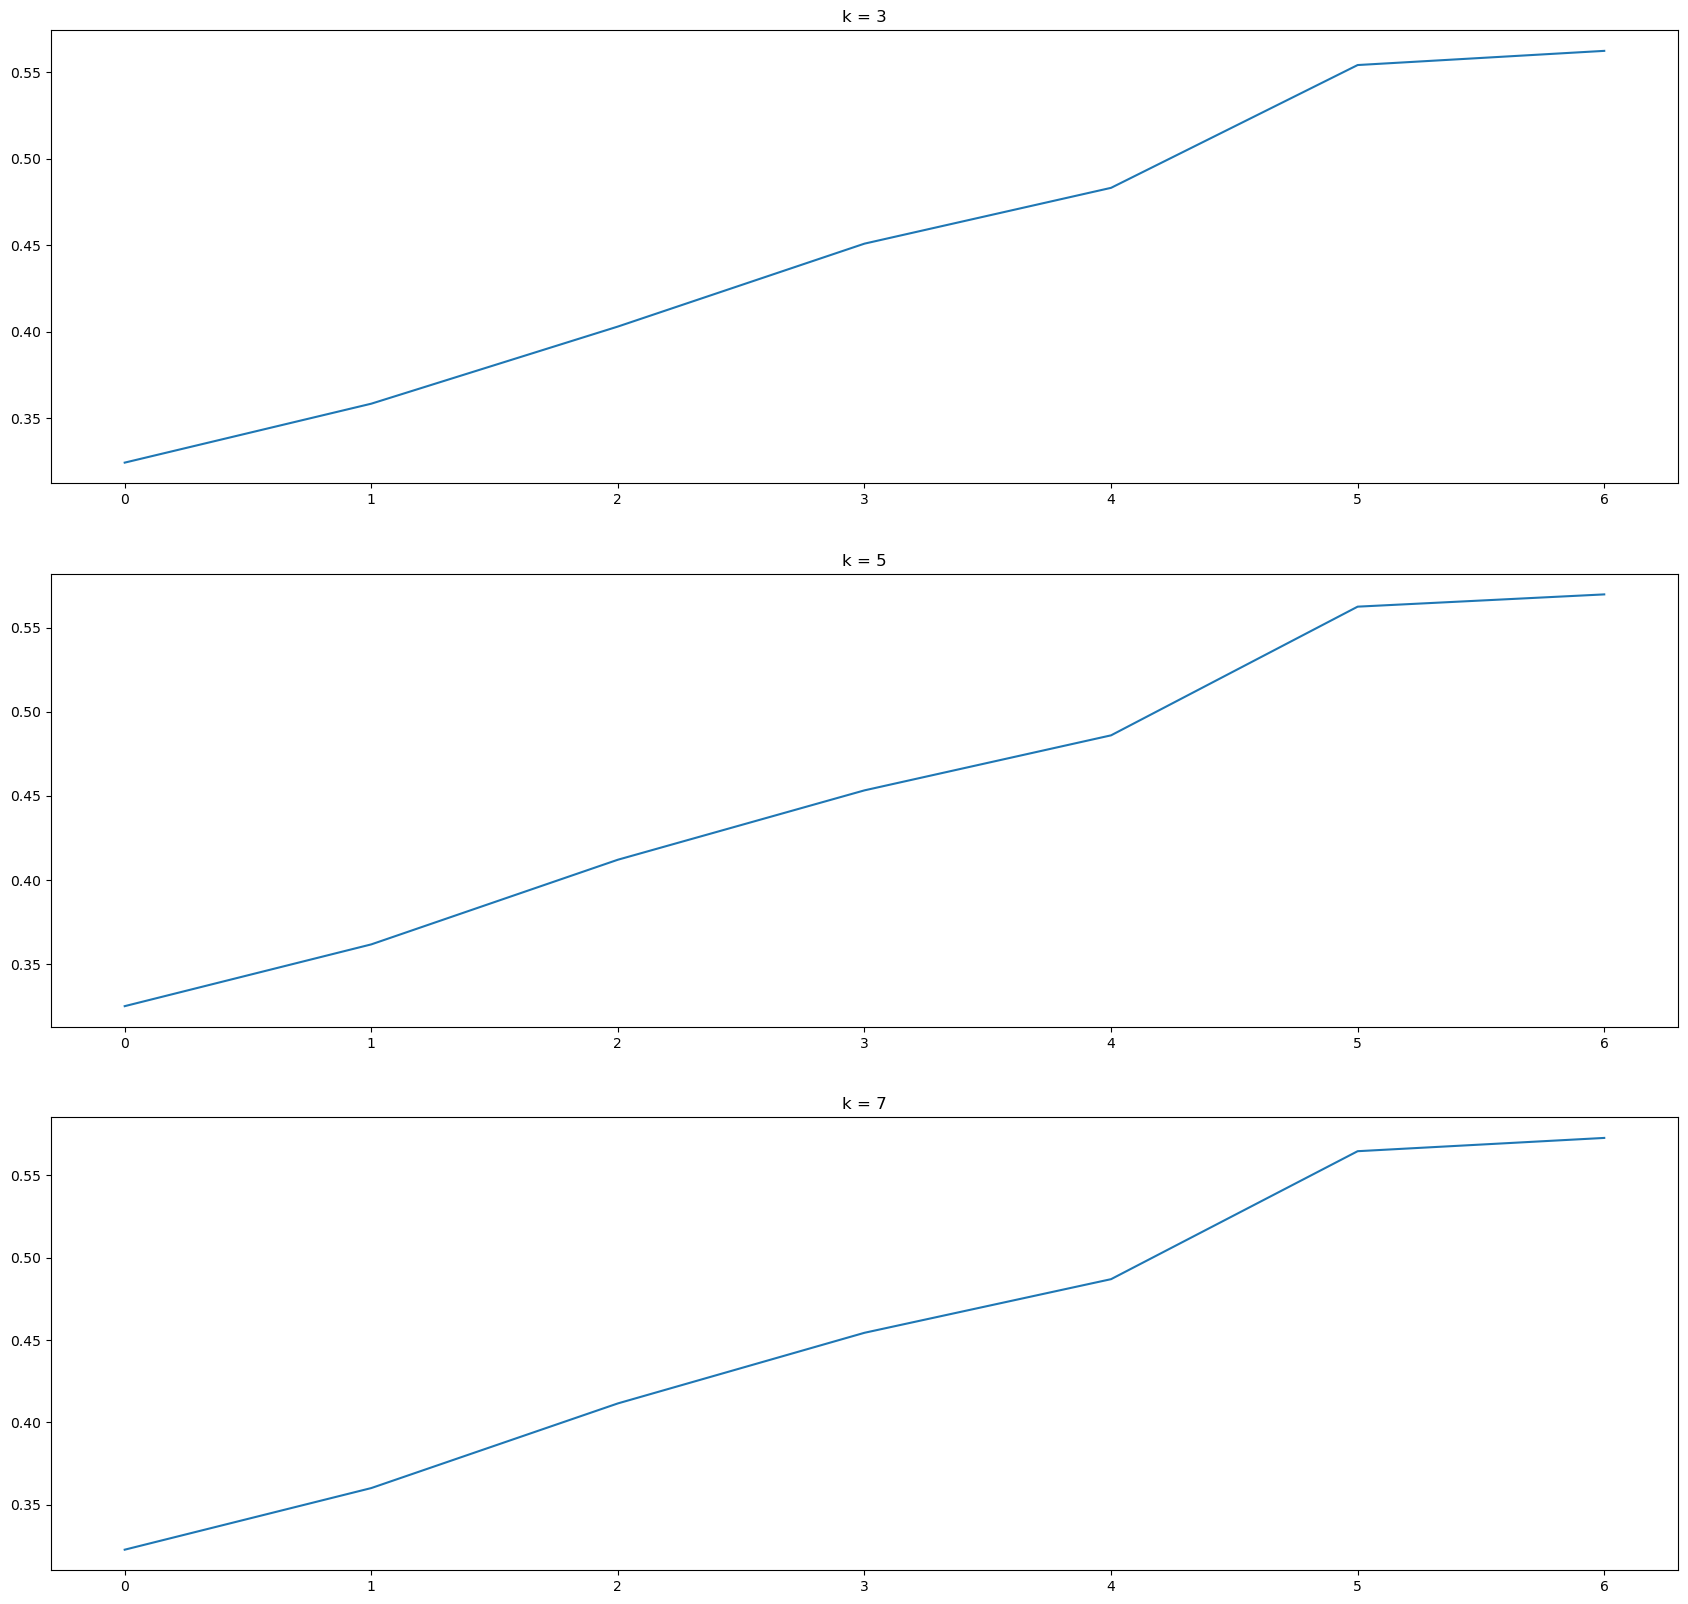

In [60]:
%%time
from sklearn.model_selection import cross_val_score
resultat_total = dict()
fig,axes = plt.subplots(nrows = 3,ncols = 1,figsize=(21,20))
for i,k in enumerate([3,5,7]):
    resultKNN_mean = []
    for ncol in [3,5,7,11,19,500,1000]:
        knn = KNeighborsClassifier(n_neighbors = k)
        resultKNN = cross_val_score(knn, X_KPCA [:,:ncol], y,  scoring='accuracy').mean()
        # report the mean performance
        resultKNN_mean.append(resultKNN)
    sns.lineplot(range(len(resultKNN_mean)),resultKNN_mean,ax = axes[i])
    text_titre = 'k = ' + str(k) 
    axes[i].set_title(text_titre)
    resultat_total[k] = resultKNN_mean

print(resultat_total)

In [65]:
%%time
resultKNN_mean = []
knnKPCA = KNeighborsClassifier(n_neighbors = 7)
resultKNN_KPCA = cross_val_score(knnKPCA, X_KPCA[:,:1000], y,  scoring='accuracy')
# report the mean performance
print('Accuracy: %.3f' % resultKNN_KPCA.mean())

Accuracy: 0.573
Wall time: 47.7 s


</br>

### KNN seul

In [68]:
%%time
resultKNN_Seul_mean = []
knnSeul = KNeighborsClassifier(n_neighbors = 7)
resultKNN_Seul_mean = cross_val_score(knnSeul, data_cleaned[['nutrition-score-fr_100g','energy_100g', 'saturated-fat_100g', 
                                               'cholesterol_100g', 'sugars_100g','fiber_100g', 'proteins_100g', 
                                               'sodium_100g', 'vitamin-a_100g','vitamin-c_100g', 'calcium_100g', 
                                               'iron_100g', 'fruits-vegetables-nuts_100g', 'bocal/conserve', 
                                               'creme/sauce', 'litre','petit pot/yaourt', 'poids', 'unité','pnns_groups_2']]\
                            .loc[data_cleaned.pnns_groups_2.notna()].drop(columns=["pnns_groups_2"]), 
                            data_cleaned.loc[data_cleaned.pnns_groups_2.notna()].pnns_groups_2,  scoring='accuracy')
# report the mean performance
print('Accuracy: %.3f' % resultKNN_Seul_mean.mean())

Accuracy: 0.520
Wall time: 4.1 s


</br>

</br>

</br>

</br>

### Comparaison de l'aliment avec l'aliment moyen de sa catégorie

In [72]:
import plotly.graph_objects as go
import plotly.offline as pyo
from sklearn import preprocessing as prep


def plot_radar_comparaison(codeprod = ''):
    std_scale = prep.StandardScaler()
    X_scaled = std_scale.fit_transform(data_cleaned[['energy_100g', 'sugars_100g', 'saturated-fat_100g','sodium_100g', 'fiber_100g', 'proteins_100g','fruits-vegetables-nuts_100g']].fillna(0))

    gp = data_cleaned.loc[data_cleaned.code == codeprod,'pnns_groups_2'].to_list()[0]
    gpH = data_cleaned.loc[data_cleaned.code == codeprod,'pnns_groups_1'].to_list()[0]
    prodName = data_cleaned.loc[data_cleaned.code == codeprod,'product_name'].to_list()[0]


    categories = ['energy_100g', 'sugars_100g', 'saturated-fat_100g','sodium_100g', 'fiber_100g', 'proteins_100g','fruits-vegetables-nuts_100g']
    categories = [*categories, categories[0]]

    aliment = X_scaled[data_cleaned.code == codeprod].tolist()[0]
    if gp is not np.nan:
        aliment_gp = X_scaled[data_cleaned.pnns_groups_2 == gp].mean( axis=0)
    elif gpH is not np.nan:
        aliment_gp = X_scaled[data_cleaned.pnns_groups_2 == gpH].mean( axis=0)
    else:
        aliment_gp = X_scaled.mean( axis=0)

    aliment = [*aliment, aliment[0]]
    aliment_gp = [*aliment_gp, aliment_gp[0]]

    name_p = 'Aliment du groupe : '+np.where(gp is not np.nan,gp,'').tolist()

    fig = go.Figure(
        data=[
            go.Scatterpolar(r=aliment_gp, theta=categories, fill='toself', name = name_p),
            go.Scatterpolar(r=aliment, theta=categories, fill='toself', name = prodName)
        ],
        layout=go.Layout(
            title=go.layout.Title(text="Comparison d'aliment"),
            polar={'radialaxis': {'visible': True}},
            showlegend=True
        )
    )

    pyo.plot(fig)


In [95]:
df_fin = data_cleaned[data_cleaned.pnns_groups_2.notna()][['code','url','product_name','pnns_groups_1','pnns_groups_2','nutrition_grade_fr','nutrition-score-fr_100g','energy_100g','saturated-fat_100g','cholesterol_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','vitamin-a_100g','vitamin-c_100g','calcium_100g','iron_100g','fruits-vegetables-nuts_100g']]\
.copy()

In [99]:
df_fin.to_csv('data_livebetterandlonger.csv',sep='\t',index=False)

In [96]:
df_fin.head()

code  \
174   290616.0   
175   394710.0   
177  1071894.0   
180  1938067.0   
182  5200016.0   

                                                                                                           url  \
174                    http://world-fr.openfoodfacts.org/produit/0000000290616/salade-cesar-kirkland-signature   
175  http://world-fr.openfoodfacts.org/produit/0000000394710/danoises-a-la-cannelle-roulees-kirkland-signature   
177                                     http://world-fr.openfoodfacts.org/produit/0000001071894/flute-waitrose   
180    http://world-fr.openfoodfacts.org/produit/0000001938067/chaussons-tresses-aux-pommes-kirkland-signature   
182                  http://world-fr.openfoodfacts.org/produit/0000005200016/lentilles-vertes-bertrand-lejeune   

                       product_name          pnns_groups_1  \
174                    Salade Cesar  fruits and vegetables   
175  Danoises à la cannelle roulées          sugary snacks   
177                           Flute   cereals and potatoes   
180    Chaussons tressés aux pommes          sugary snacks   
182               lentilles vertes    cereals and potatoes   

          pnns_groups_2 nutrition_grade_fr  nutrition-score-fr_100g  \
174          vegetables                  c                      6.0   
175  biscuits and cakes                NaN                     15.0   
177               bread                NaN                      9.0   
180  biscuits and cakes                  c                      9.0   
182             legumes                NaN                      9.0   

     energy_100g  saturated-fat_100g  cholesterol_100g  sugars_100g  \
174       1210.0                 7.0               0.0          0.0   
175       1520.0                 7.0               0.0         28.0   
177       1135.0                 4.0               0.0         13.0   
180       1090.0                 2.0               0.0         25.0   
182       1177.0                 4.0               0.0         14.0   

     fiber_100g  proteins_100g  sodium_100g  vitamin-a_100g  vitamin-c_100g  \
174         2.0           22.0          1.0             0.0             0.0   
175         2.0            5.0          0.0             0.0             0.0   
177         2.0            6.0          0.0             0.0             0.0   
180         2.0            3.0          0.0             0.0             0.0   
182         2.0            6.0          0.0             0.0             0.0   

     calcium_100g  iron_100g  fruits-vegetables-nuts_100g  
174           0.0        0.0                         45.0  
175           0.0        0.0                         35.0  
177           0.0        0.0                         31.0  
180           0.0        0.0                         33.0  
182           0.0        0.0                         31.0

In [114]:
testedcode = df_fin['code'].sample().values[0]
testedcode

3373800300067.0

In [115]:
gpAliment = df_fin[df_fin.code==testedcode].pnns_groups_2
gpAliment.values[0]

'fish and seafood'

In [94]:
df_fin.loc[df_fin.pnns_groups_2==gpAliment.values[0]].sort_values(by =['nutrition_grade_fr','nutrition-score-fr_100g'] ).head(10)

code  \
208075  3.256223e+12   
306899  8.437008e+12   
313056  8.850782e+12   
87562   7.487396e+10   
249053  3.760031e+12   
269552  5.032105e+12   
199690  3.229820e+12   
210006  3.257982e+12   
227927  3.396410e+12   
240710  3.564707e+12   

                                                              product_name  \
208075                                              Boisson au Soja nature   
306899  Bebida de soja ecológica &quot;NaturGreen&quot; con cacao y calcio   
313056                                                        Coconut milk   
87562                                         Organic Unsweetened soy milk   
249053                                                       Lait d'Amande   
269552                                         Upbeat Blueberry & Rapberry   
199690                                         Soja douceur et calcium BIO   
210006                                              Boisson au Soja Nature   
227927                                         Soja Sélection Doux Calcium   
240710                                              Boisson au Soja Nature   

       pnns_groups_1          pnns_groups_2 nutrition_grade_fr  \
208075     beverages  non sugared beverages                  a   
306899     beverages  non sugared beverages                  a   
313056     beverages  non sugared beverages                  a   
87562      beverages  non sugared beverages                  a   
249053     beverages  non sugared beverages                  a   
269552     beverages  non sugared beverages                  a   
199690     beverages  non sugared beverages                  a   
210006     beverages  non sugared beverages                  a   
227927     beverages  non sugared beverages                  a   
240710     beverages  non sugared beverages                  a   

        nutrition-score-fr_100g  energy_100g  saturated-fat_100g  \
208075                     -5.0        171.0                 1.0   
306899                     -5.0        318.0                 0.0   
313056                     -5.0        502.0                 1.0   
87562                      -4.0        157.0                 0.0   
249053                     -4.0       1638.0                 1.0   
269552                     -4.0        244.0                 0.0   
199690                     -3.0        209.0                 0.0   
210006                     -3.0        159.0                 0.0   
227927                     -3.0        222.0                 0.0   
240710                     -3.0        151.0                 0.0   

        cholesterol_100g  sugars_100g  fiber_100g  proteins_100g  sodium_100g  \
208075               0.0          1.0         1.0            8.0          0.0   
306899              -0.0          8.0         3.0            4.0          0.0   
313056               0.0          3.0         1.0           12.0          0.0   
87562                0.0          0.0         2.0            4.0          0.0   
249053              -0.0          6.0         5.0            9.0          0.0   
269552               0.0          4.0         0.0            8.0          0.0   
199690               0.0          3.0         1.0            4.0          0.0   
210006               0.0          0.0         1.0            4.0          0.0   
227927               0.0          3.0         1.0            4.0          0.0   
240710               0.0          1.0         1.0            4.0          0.0   

        vitamin-a_100g  vitamin-c_100g  calcium_100g  iron_100g  \
208075             0.0             0.0           0.0        0.0   
306899             0.0             0.0           0.0        0.0   
313056             0.0             0.0           0.0        0.0   
87562              0.0             0.0           0.0        0.0   
249053             0.0             0.0           0.0        0.0   
269552             0.0             0.0           0.0        0.0   
199690             0.0             0.0           0.0   

In [127]:
gpAliment = df_fin[df_fin.code==testedcode].pnns_groups_2
nutriAliment = df_fin.loc[df_fin.code==testedcode,'nutrition-score-fr_100g']
nutriAliment.values[0]

#df_fin.loc[(df_fin.pnns_groups_2==gpAliment.values[0]) & (df_fin['nutrition-score-fr_100g'] <= nutriAliment) ]

-2.0

In [130]:
def best_food(code):
    gpAliment = df_fin[df_fin.code==code].pnns_groups_2
    print("C'est un aliment du groupe: ",gpAliment.values[0],"\n")
    
    nutriAliment = df_fin.loc[df_fin.code==testedcode,'nutrition-score-fr_100g']
    
    df_best_food_list = df_fin.loc[(df_fin.pnns_groups_2==gpAliment.values[0]) & (df_fin['nutrition-score-fr_100g'] <= nutriAliment.values[0]) ]
    df_best_food_list =df_best_food_list.sort_values(by =['nutrition_grade_fr','nutrition-score-fr_100g'] )
    return df_best_food_list[['code','url','product_name','pnns_groups_1','pnns_groups_2','nutrition_grade_fr','nutrition-score-fr_100g']]
    

In [116]:
plot_radar_comparaison(codeprod = testedcode)

In [133]:
best_food(code = testedcode)

C'est un aliment du groupe:  fish and seafood 



code  \
210889  3.258561e+12   
175558  2.011712e+07   
177174  2.040297e+07   
177817  2.052558e+07   
180706  2.324179e+12   
182191  2.602666e+07   
182886  2.609859e+07   
198826  3.222476e+12   
206225  3.254560e+12   
206768  3.256220e+12   
214547  3.263860e+12   
216075  3.270121e+12   
216080  3.270160e+12   
216233  3.270160e+12   
216251  3.270160e+12   
216254  3.270160e+12   
216723  3.270161e+12   
220952  3.292591e+12   
226212  3.368953e+12   
229679  3.426434e+12   
235965  3.560071e+12   
238229  3.564700e+12   
244836  3.599740e+12   
244873  3.599740e+12   
248626  3.760021e+12   
262670  4.311501e+12   
272883  5.391520e+12   
62379   5.135170e+05   
174426  2.000183e+07   
175948  2.017455e+07   
176749  2.031640e+07   
179923  2.212429e+07   
182573  2.605304e+07   
184667  3.013520e+12   
197908  3.222473e+12   
197920  3.222473e+12   
201409  3.245413e+12   
203188  3.250391e+12   
204698  3.250392e+12   
204811  3.250392e+12   
206359  3.254564e+12   
206747  3.256220e+12   
207550  3.256221e+12   
211984  3.263670e+12   
214531  3.263860e+12   
216231  3.270160e+12   
216247  3.270160e+12   
216248  3.270160e+12   
216255  3.270160e+12   
216257  3.270160e+12   
216267  3.270160e+12   
216305  3.270160e+12   
216731  3.270161e+12   
216736  3.270161e+12   
216737  3.270161e+12   
224017  3.346960e+12   
224282  3.350030e+12   
229681  3.426434e+12   
229683  3.426434e+12   
229684  3.426434e+12   
230965  3.450970e+12   
233351  3.503594e+12   
238045  3.564700e+12   
238207  3.564700e+12   
244809  3.599740e+12   
244810  3.599740e+12   
244835  3.599740e+12   
244837  3.599740e+12   
244874  3.599740e+12   
244901  3.599741e+12   
246378  3.661405e+12   
247104  3.700163e+12   
248127  3.700968e+12   
250856  3.760123e+12   
252227  3.760235e+12   
257303  4.012482e+12   
257304  4.012482e+12   
257691  4.014760e+12   
262434  4.311501e+12   
262908  4.311596e+12   
274147  5.400247e+12   
274283  5.400247e+12   
274339  5.400247e+12   
278709  5.704025e+12   
280344  6.181460e+12   
281156  6.925477e+12   
291257  7.613312e+12   
310695  8.712565e+12   
177588  2.047235e+07   
178140  2.059331e+07   
183403  2.702459e+12   
197527  3.222472e+12   
197911  3.222473e+12   
207349  3.256221e+12   
207549  3.256221e+12   
213734  3.263858e+12   
214544  3.263860e+12   
216228  3.270160e+12   
216236  3.270160e+12   
216264  3.270160e+12   
216443  3.270160e+12   
219217  3.276770e+12   
222145  3.325096e+12   
222364  3.329151e+12   
222365  3.329151e+12   
224821  3.350032e+12   
227758  3.392780e+12   
229677  3.426434e+12   
229680  3.426434e+12   
229682  3.426434e+12   
229685  3.426434e+12   
238044  3.564700e+12   
241167  3.567891e+12   
241168  3.567891e+12   
241836  3.586410e+12   
250851  3.760122e+12   
261529  4.250241e+12   
262439  4.311501e+12   
262566  4.311501e+12   
274142  5.400247e+12   
276385  5.411788e+12   
281029  6.920240e+12   
285681  7.610830e+12   
314784  9.300462e+12   
173195  2.000000e+12   
177636  2.048812e+07   
178460  2.065739e+07   
178575  2.068188e+07   
181749  2.564782e+12   
187753  3.038688e+12   
197131  3.222471e+12   
197364  3.222472e+12   
199065  3.222476e+12   
200914  3.245390e+12   
203318  3.250391e+12   
205493  3.251228e+12   
207321  3.256221e+12   
210129  3.257982e+12   
210238  3.257983e+12   
210435  3.257984e+12   
210996  3.258561e+12   
211578  3.261080e+12   
212683  3.263851e+12   
214270  3.263860e+12   
216234  3.270160e+12   
216240  3.270160e+12   
216250  3.270160e+12   
216439  3.270160e+12   
217559  3.270190e+12   
218648  3.274570e+12   
219215  3.276770e+12   
223455  3.336374e+12   
224540  3.350030e+12   
225832  3.365621e+12   
225860  3.365623e+12   
226583  3.373800e+12   
232756  3.492500e+12   
238669  3.564700e+12   
239739  3.564701e+12   
249821  3.760075e+12   
249827  3.760075e+12   
251289  3.760148e+12   
261530  4.250241e+12   
262601  4.311501e+12   
262846  4.311596e+12   
263658  4.388844e+12   
270747  

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

</br>

In [ ]:
%whos